### Основные выводы по данным

Посмотрим на средние рейтинга фильмов, количества голосов и кассовых сборов относительно бинарного признака is_found (нашел ли аггоритм фильм или нет). Видим, что отличие статистически значимо во всех трех случаях. Это означает, что алгоритм чаще находит фильмы с бОльшим рейтингом, или бюджетом, или количеством голосов. Правда, несмотря на то, что интервалы не пересекаются во всех трех случаях, в случае с рейтингом, границы интервалов расположены близко друг у другу, средние, оцененные по выборкам также примерно равны, алгоритм все равно различает эту небольшую разницу, но это может быть связано с тем, что стандартное отклонение признака небольшое и составляет 1.34 при среднем в 6.15. В случае же с количесвом голосов и кассовыми сборами, алгоритм менее успешен. Основной action point: модифицировать алгоритм таким образом, чтобы он находил больше фильмов с маленьким количесвом голосов и кассовыми сборами. Потенциальные будущие действия: выявить другие признаки, позволяющие уловить необходимые улучшения алгоритма.

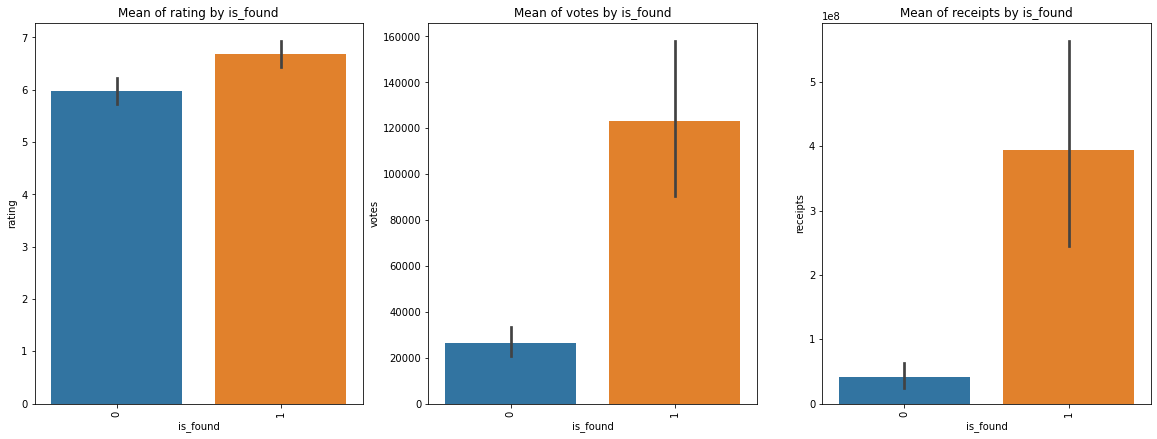

In [173]:
plt.figure(figsize=(20, 7))
for i, column in enumerate(['rating', 'votes', 'receipts']):
    plt.subplot(1, 3, i+1)
    ax = sns.barplot(x='is_found', y=column, data=data)
    plt.title('Mean of {} by is_found'.format(column))
    plt.xticks(rotation=90)
plt.subplots_adjust(hspace=1)
plt.show()

In [193]:
np.mean(data['rating'].values), np.std(data['rating'].values)

(6.151648351648351, 1.3386776021497047)

 ### Дополнительные выводы

Предложенный алгоритм смог обнаружить упоминания о 44 фильмах в новостях за период двух лет, что составляет 25 % от общего количества фильмов в данных. Согласно потроенным доверительным интервалам, можно с уровнем значимости в 95 % утверждать, что доля найденных фильмов из США больше чем из Великобритании. По остальным странам оцененная по выборке доля найденых фильмов из США также выше, но нельзя сделать однозначных выводов, так как интервалы пересекаются. Так, доля найденных фильмов из России составила чуть выше 0.2, в то время как из США - чуть менее 0.4. Основная проблема при сравнении долей заключается в том, что некоторые фильмы по странам представлены в крайне ограниченном количестве в выборке, и по ним нельзя построить доверительный интервал (например, в выборке всего два фильма из Италии). Следуя схожей логике, можно сделать вывод о средних по другим категориальным признакам (интервалы также пересекаются, но можно примерно оценить по выборке).

Относительно количества извлекаемых сущностей, видим, что среднее количество извлекаемых сущностей фильмов из США больше, чем отальных по отдельности. Канаду в расчет не берем из-за ограниченного объема выборки. Это говорит о том, что статьи о фильмах из США более насыщены и включают больше сущностей из данных. Среднее количество сущностей по бинарному признаку дети / взрослые примерно одинаков. Также видим, что среднее количество извлекаемых сущностей из новостей о зарубежных фильмах выше, чем о российских, интервалы не пересекаются. Но если принимать в расчет количество уникальных сущностей, то эта разница исчезает и интервалы пересекаются, что говорит о том, что количество извлекаемых уникальных сущностей примерно одинаково по странам.

Возможные улучшения: более мощный алгоритм поиска, большее количетво данных с равными пропорциями по странам и другим категориальным признакам для возможности построения доверительных интервалов и проверки гипотез.

In [156]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
from pymystem3 import Mystem
import itertools
from nltk.tokenize import WordPunctTokenizer
from spacy.lang.ru.stop_words import STOP_WORDS
import scipy
import numpy as np

In [110]:
data = pd.read_csv('/Users/artyomkholodkov/Downloads/Список тайтлов для упоминаний в новостях.csv', delimiter=';')

In [111]:
data.head(5)

,object_id,title,orig_country,release_date,for_children,about,characters,category_property,place,tima,theme,classifier
0,419411,За деревьями,США,21.11.2019,0,"['демоны','отношения в паре','путешествия','бо...",NaN,"['демоны','отношения в паре','путешествия','бо...","['лес или джунгли','Индия']",21-й век,психологический,NaN
1,210525,Сиротский Бруклин,США,30.08.2019,0,"['потеря близких','частные детективы или сыщик...",NaN,"['потеря близких','частные детективы или сыщик...","['США, Нью-Йорк','США']",21-й век,психологический,Зарубежные фильмы
2,176620,Тайная жизнь домашних животных 2,США,24.05.2019,1,"['психологические расстройства','переезд','дет...",NaN,"['психологические расстройства','переезд','дет...","['большой город','США']",21-й век,"['авантюрные','развлекательные']",Анимация
3,185387,Борьба с моей семьей,Великобритания,28.01.2019,0,"['семейный конфликт','подростки','успех','отно...",NaN,"['семейный конфликт','подростки','успех','отно...","['Великобритания','США']",21-й век,развлекательные,Зарубежные фильмы
4,12678,BH90210,США,07.08.2019,0,"['дружба','отношения мужчины и женщины','любов...",NaN,"['дружба','отношения мужчины и женщины','любов...","['США','маленький городок']",21-й век,развлекательные,Зарубежные сериалы


Посмотрим на информацию о DataFrame

In [112]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   object_id          184 non-null    int64  
 1   title              184 non-null    object 
 2   orig_country       184 non-null    object 
 3   release_date       184 non-null    object 
 4   for_children       184 non-null    int64  
 5   about              184 non-null    object 
 6   characters         0 non-null      float64
 7   category_property  184 non-null    object 
 8   place              182 non-null    object 
 9   tima               184 non-null    object 
 10  theme              184 non-null    object 
 11  classifier         166 non-null    object 
dtypes: float64(1), int64(2), object(9)
memory usage: 17.4+ KB


Убираем поле characters, так как в нем отсутствуют значения. Удаляем поле category_property, так как оно идентично about

In [113]:
data.drop(['characters'], axis=1, inplace=True)

In [114]:
data['similarity'] = data.apply(lambda x: 1 if x['about'] == x['category_property'] else 0, axis=1)

In [115]:
data.head(5)

,object_id,title,orig_country,release_date,for_children,about,category_property,place,tima,theme,classifier,similarity
0,419411,За деревьями,США,21.11.2019,0,"['демоны','отношения в паре','путешествия','бо...","['демоны','отношения в паре','путешествия','бо...","['лес или джунгли','Индия']",21-й век,психологический,NaN,1
1,210525,Сиротский Бруклин,США,30.08.2019,0,"['потеря близких','частные детективы или сыщик...","['потеря близких','частные детективы или сыщик...","['США, Нью-Йорк','США']",21-й век,психологический,Зарубежные фильмы,1
2,176620,Тайная жизнь домашних животных 2,США,24.05.2019,1,"['психологические расстройства','переезд','дет...","['психологические расстройства','переезд','дет...","['большой город','США']",21-й век,"['авантюрные','развлекательные']",Анимация,1
3,185387,Борьба с моей семьей,Великобритания,28.01.2019,0,"['семейный конфликт','подростки','успех','отно...","['семейный конфликт','подростки','успех','отно...","['Великобритания','США']",21-й век,развлекательные,Зарубежные фильмы,1
4,12678,BH90210,США,07.08.2019,0,"['дружба','отношения мужчины и женщины','любов...","['дружба','отношения мужчины и женщины','любов...","['США','маленький городок']",21-й век,развлекательные,Зарубежные сериалы,1


In [116]:
data['similarity'].value_counts()

1    184
Name: similarity, dtype: int64

In [117]:
data.drop(['category_property', 'similarity'], axis=1, inplace=True)

Визуализируем распределения категориальных признаков

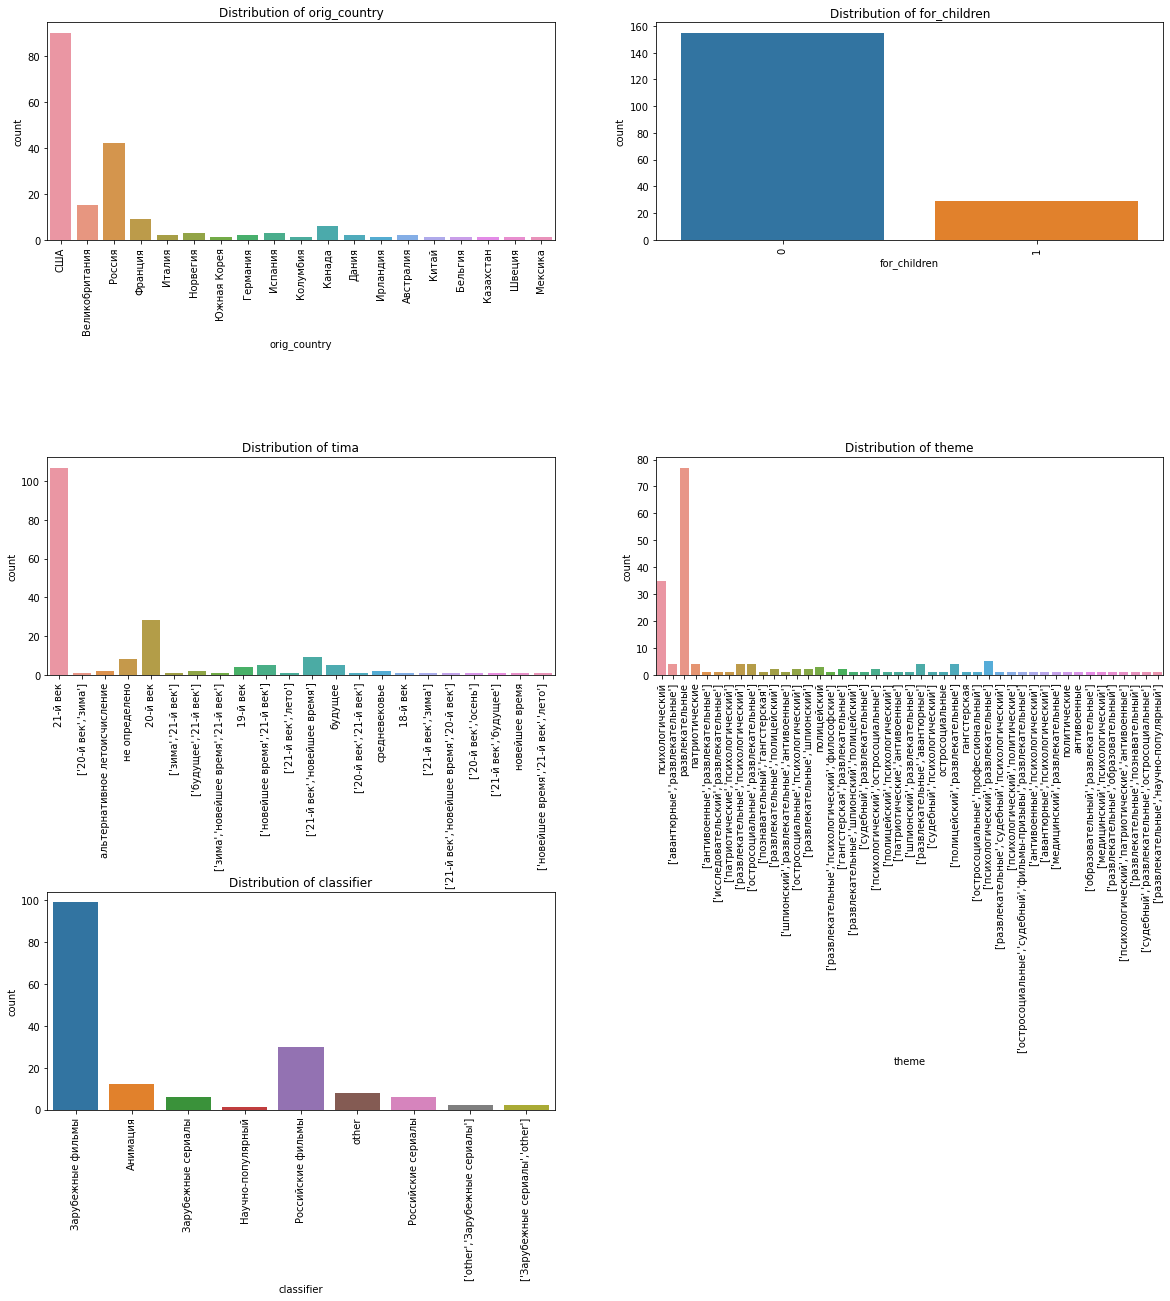

In [118]:
plt.figure(figsize = (20, 20))
for i, column in enumerate(['orig_country', 'for_children', 'tima', 'theme', 'classifier']):
    plt.subplot(3, 2, i+1)
    ax = sns.countplot(x=column, data=data)
    plt.title('Distribution of {}'.format(column))
    plt.xticks(rotation=90)
    
plt.subplots_adjust(hspace=1)
plt.show()

В поле classifier сливаем значения "['Зарубежные сериалы','other']" и "['other','Зарубежные сериалы']" в 'Зарубежные сериалы', так как они схожи по смыслу

In [119]:
data['classifier'] = data.apply(lambda x: 'Зарубежные сериалы' if x['classifier'] == "['Зарубежные сериалы','other']" 
                or x['classifier'] == "['other','Зарубежные сериалы']" else x['classifier'], axis=1)

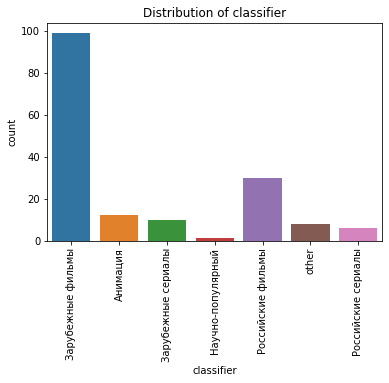

In [120]:
plt.figure()
ax = sns.countplot(x='classifier', data=data)
plt.title('Distribution of classifier')
plt.xticks(rotation=90)
plt.show()

Чистим данные и заполняем пропущенные значения

In [121]:
data['about'] = data.apply(lambda x: x['about'].replace('\'', '').strip('[]').split(','), axis=1)

In [122]:
data.loc[33, 'place'] = "['Севилья','Испания']"
data.loc[86, 'place'] = "['Санкт-Петербург', 'Россия']"

In [123]:
data['place'] = data.apply(lambda x: x['place'].replace('\'', '').strip('[]').split(','), axis=1)

In [124]:
data.loc[0, 'classifier'] = 'Зарубежные фильмы'
data.loc[5, 'classifier'] = 'Российские фильмы'
data.loc[17, 'classifier'] = 'Российские сериалы'
data.loc[26, 'classifier'] = 'Зарубежные фильмы'
data.loc[33, 'classifier'] = 'Зарубежные фильмы'
data.loc[44, 'classifier'] = 'Зарубежные фильмы'
data.loc[52, 'classifier'] = 'Зарубежные сериалы'
data.loc[68, 'classifier'] = 'Зарубежные фильмы'
data.loc[87, 'classifier'] = 'Зарубежные сериалы'
data.loc[119, 'classifier'] = 'Зарубежные фильмы'
data.loc[125, 'classifier'] = 'Зарубежные сериалы'
data.loc[126, 'classifier'] = 'Зарубежные фильмы'
data.loc[148, 'classifier'] = 'Российские фильмы'
data.loc[160, 'classifier'] = 'Зарубежные сериалы'
data.loc[161, 'classifier'] = 'Зарубежные фильмы'
data.loc[170, 'classifier'] = 'Зарубежные фильмы'
data.loc[173, 'classifier'] = 'Зарубежные фильмы'
data.loc[181, 'classifier'] = 'Зарубежные сериалы'

In [125]:
data['tima'] = data.apply(lambda x: x['tima'].replace('\'', '').strip('[]').split(','), axis=1)

In [126]:
data['theme'] = data.apply(lambda x: x['theme'].replace('\'', '').strip('[]').split(','), axis=1)

In [127]:
data.loc[44, 'title'] = 'Достать ножи'
data.loc[68, 'title'] = 'Однажды в… Голливуде'

In [128]:
data.head(5)

,object_id,title,orig_country,release_date,for_children,about,place,tima,theme,classifier
0,419411,За деревьями,США,21.11.2019,0,"[демоны, отношения в паре, путешествия, борьба...","[лес или джунгли, Индия]",[21-й век],[психологический],Зарубежные фильмы
1,210525,Сиротский Бруклин,США,30.08.2019,0,"[потеря близких, частные детективы или сыщики,...","[США, Нью-Йорк, США]",[21-й век],[психологический],Зарубежные фильмы
2,176620,Тайная жизнь домашних животных 2,США,24.05.2019,1,"[психологические расстройства, переезд, дети, ...","[большой город, США]",[21-й век],"[авантюрные, развлекательные]",Анимация
3,185387,Борьба с моей семьей,Великобритания,28.01.2019,0,"[семейный конфликт, подростки, успех, отношени...","[Великобритания, США]",[21-й век],[развлекательные],Зарубежные фильмы
4,12678,BH90210,США,07.08.2019,0,"[дружба, отношения мужчины и женщины, любовь, ...","[США, маленький городок]",[21-й век],[развлекательные],Зарубежные сериалы


Особенностью значений токенизированных сущностей является то, что они не обязательно совпадают по грамматической форме с сущностями в самом тексте статьи, что усложняет их обнаружение в тексте. Для того, чтобы этого избежать и повысить уровень обнаружения, можно лемматизировать как сами словоформы в данных, так и в самом тексте статьи. Лемматиза́ция — процесс приведения словоформы к лемме — её нормальной (словарной) форме. Токенизация (разбиение предложений на слова) осуществляется при помощи объекта класса WordPunctTokenizer из библиотеки nltk. Лемматизация осуществляется при помощи объекта класса Mystem из библиотеки pymystem3. Произведем токенизацию и лемматизацию данных:

In [129]:
tokenizer = WordPunctTokenizer()
mystem = Mystem()

In [130]:
data['about'] = data['about'].apply(lambda x: [mystem.lemmatize(word)[0] for word in 
                                    list(itertools.chain(*[tokenizer.tokenize(el.lower()) for el in x]))])

data['about'] = data['about'].apply(lambda x: [word for word in x if not word in STOP_WORDS])

data['place'] = data['place'].apply(lambda x: [mystem.lemmatize(word)[0] for word in 
                                    list(itertools.chain(*[tokenizer.tokenize(el.lower()) for el in x]))])

data['place'] = data['place'].apply(lambda x: [word for word in x if not word in STOP_WORDS])

data['tima'] = data['tima'].apply(lambda x: [mystem.lemmatize(word)[0] for word in 
                                    list(itertools.chain(*[tokenizer.tokenize(el.lower()) for el in x]))])

data['theme'] = data['theme'].apply(lambda x: [mystem.lemmatize(word)[0] for word in 
                                    list(itertools.chain(*[tokenizer.tokenize(el.lower()) for el in x]))])

data['classifier'] = data['classifier'].apply(lambda x: [x])

data['classifier'] = data['classifier'].apply(lambda x: [mystem.lemmatize(word)[0] for word in 
                                    list(itertools.chain(*[tokenizer.tokenize(el.lower()) for el in x]))])

data['title_lem'] = data['title'].apply(lambda x: [mystem.lemmatize(word)[0] for word in 
                                                                            tokenizer.tokenize(x.lower())])

data['orig_country_lem'] = data['orig_country'].apply(lambda x: [mystem.lemmatize(word)[0] for word in 
                                                                            tokenizer.tokenize(x.lower())])

data['release_date_stem'] = data['release_date'].apply(lambda x: [x])

data['release_year'] = data['release_date'].apply(lambda x: [x[-4:]])

data['all'] = data.apply(lambda x: x['about'] + x['place'] + x['tima'] + x['theme'] + x['classifier'] + 
                         x['title_lem'] + x['orig_country_lem'] + x['release_date_stem'], axis=1)


In [131]:
data.head(5)

,object_id,title,orig_country,release_date,for_children,about,place,tima,theme,classifier,title_lem,orig_country_lem,release_date_stem,release_year,all
0,419411,За деревьями,США,21.11.2019,0,"[демон, отношение, пара, путешествие, борьба, ...","[лес, джунгли, индия]","[21, -\n, й, век]",[психологический],"[зарубежный, фильм]","[за, дерево]",[сша],[21.11.2019],[2019],"[демон, отношение, пара, путешествие, борьба, ..."
1,210525,Сиротский Бруклин,США,30.08.2019,0,"[потеря, близкие, частный, детектив, сыщик, пр...","[сша, нью, -\n, йорк, сша]","[21, -\n, й, век]",[психологический],"[зарубежный, фильм]","[сиротский, бруклин]",[сша],[30.08.2019],[2019],"[потеря, близкие, частный, детектив, сыщик, пр..."
2,176620,Тайная жизнь домашних животных 2,США,24.05.2019,1,"[психологический, расстройство, переезд, ребен...","[большой, город, сша]","[21, -\n, й, век]","[авантюрный, развлекательный]",[анимация],"[тайный, жизнь, домашний, животный, 2]",[сша],[24.05.2019],[2019],"[психологический, расстройство, переезд, ребен..."
3,185387,Борьба с моей семьей,Великобритания,28.01.2019,0,"[семейный, конфликт, подросток, успех, отношен...","[великобритания, сша]","[21, -\n, й, век]",[развлекательный],"[зарубежный, фильм]","[борьба, с, мой, семья]",[великобритания],[28.01.2019],[2019],"[семейный, конфликт, подросток, успех, отношен..."
4,12678,BH90210,США,07.08.2019,0,"[дружба, отношение, мужчина, женщина, любовь, ...","[сша, маленький, городок]","[21, -\n, й, век]",[развлекательный],"[зарубежный, сериал]",[bh90210],[сша],[07.08.2019],[2019],"[дружба, отношение, мужчина, женщина, любовь, ..."


Удалим дубликаты строк

In [132]:
data.drop([44, 68], axis=0, inplace=True)

In [133]:
data.reset_index(drop=True, inplace=True)

In [134]:
data.loc[4, 'title'] = 'Беверли-Хиллз 90210'
data.loc[86, 'title'] = 'Хорошая жена'

Будем парсить данные с сайта "Кипопоиск". Сгенерируем url страниц, с которых будут парситься данные. url соответсвуют периоду с середины 2018 до середины 2020 года. Это нужно для того, чтобы уловить новости перед выходом фильма в прокат, а также для новостей, относящихся с сиквелам

In [135]:
urls = ['https://www.kinopoisk.ru' + '/media/news/?page={}'.format(x) for x in range(20, 122)]

Функция извлекающая заголовок статьи и ссылки с новостных ячеек на одной странице:

In [136]:
def page_grids_info(url):
    grids_info = [] #list of dicts
    
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    grids = soup.find_all('div', class_='posts-grid__main-section-column')
    
    for grid in grids:
        if grid.find('div', class_='post-feature-card__inner') is not None:
            text = grid.find('div', class_='post-feature-card__title-wrapper').text.replace('\xa0', ' ').replace('«', '').replace('»', '').lower()
            text = tokenizer.tokenize(text)
            
            link = 'https://www.kinopoisk.ru' + grid.find('a', class_='post-feature-card__link', href=True)['href']
        else:
            text = grid.find('div', class_='_3RBVh-8DsmxMT0AuAT4h-U').find('h3').find('span').text.replace('\xa0', ' ').replace('«', '').replace('»', '').lower()
            text = tokenizer.tokenize(text)
            
            link = 'https://www.kinopoisk.ru' + grid.find('a', class_='WH0s4mM3McoTk8gEm5kNm', href=True)['href']
        
        grids_info.append({'text': text, 'link': link})
        
    return grids_info

В самих новостях на сайте "Кипопоиск" содержатся карточки фильмов, если они упомянуты в тексте статьи. Нижеприведенная функция извлекает токены статьи и лемматизирует их, если название фильма из поля title в данных соответстсвует названию в карточке фильма.

In [137]:
def get_page_tokens(url, title):
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    
    cards = soup.find_all('div', class_= 'stk-reset')

    titles_array = []
    for card in cards:
        try:
            titles_array.append(card['data-title'])
        except KeyError:
            pass
    
    if len(titles_array) == 1 and title.lower() in titles_array[0].lower():
        header = soup.find('h1', class_='media-post-title').text.replace('\xa0', ' ').replace('«', '').replace('»', '').lower()
        header = tokenizer.tokenize(header)
    
        body = soup.find('div', class_='media-post-body').text.replace('\xa0', ' ').replace('«', '').replace('»', '').lower()
        body = tokenizer.tokenize(body)
    
        header_tokens_lem = [mystem.lemmatize(word)[0] for word in header]
        body_tokens_lem = [mystem.lemmatize(word)[0] for word in body]
    
        text = header_tokens_lem + body_tokens_lem
        
        return text
    else:
        return None
    
    

Парсим данные. Если в названии статьи содержится хотя-бы 50% лемматизированных слов из названия фильма из поля title, переходим на страницу статьи и сверяем название фильма из карточки на сайте с названием из поля title. Если название совпадает, извлекаем все лемматизированные токены статьи и сверяем, какие из них содержатся в токенах в данных. Такая стратения может быть не совсем оптимальной, но позволяет значительно ускорить парсинг. Если токен найден, то он заносится в массив в словаре, ключ которого соответсвует названию фильма.

In [138]:
def in_sequence(seq1: list, seq2: list):    
    if sum([el in seq2 for el in seq1]) / len(seq1) >= 0.5:
        return True
    else:
        return False

In [101]:
all_titles_tokens = {k: [] for k in data['title'].values}

In [ ]:
for i in range(len(data)):
    for url in urls:
        page_info = page_grids_info(url)
        for grid_info in page_info:
            lem_grid_title = [mystem.lemmatize(word)[0] for word in grid_info['text']]
            if in_sequence(data.loc[i, 'title_lem'], lem_grid_title):
                page_tokens = get_page_tokens(grid_info['link'], data.loc[i, 'title'])
                if page_tokens is not None:
                    for data_token in data.loc[i, 'all']:
                        if data_token in page_tokens:
                            all_titles_tokens[data.loc[i, 'title']].append(data_token)

Найдем процент найденных фильмов в новостях и их количество

In [139]:
percentage = len({k: v for k, v in all_titles_tokens.items() if v != []}) / len(all_titles_tokens) * 100
amount = len({k: v for k, v in all_titles_tokens.items() if v != []})
print('Процент найденных фильмов в новостях: {} %'.format(round(percentage, 2)))
print('Количество найденных фильмов в новостях: {}'.format(amount))

Процент найденных фильмов в новостях: 24.18 %
Количество найденных фильмов в новостях: 44


Присоединим найденные токены к DataFrame

In [140]:
tokens = pd.DataFrame({'tokens': list(all_titles_tokens.values())})
data = data.join(tokens)

In [141]:
data['place'] = data['place'].apply(lambda x: ' '.join(x))
data['tima'] = data['tima'].apply(lambda x: ' '.join(x))
data['theme'] = data['theme'].apply(lambda x: ' '.join(x))
data['classifier'] = data['classifier'].apply(lambda x: ' '.join(x))

In [142]:
data['tima'] = data['tima'].apply(lambda x: x.replace('\n', ''))

Присоединим количество найденных токенов по фильмам, а также создадим бинарный признак (0 - если фильм не найден в новостях, 1 - если найден)

In [143]:
data['num_tokens'] = data['tokens'].apply(lambda x: len(x))

In [144]:
data['is_found'] = data['tokens'].apply(lambda x: 0 if x == [] else 1)

Визуализируем долю найденных фильмов по различным категориальным признакам (правая колонка) по отношению к счетчику фильмов по этим признакам (левая колонка). Метод barplot библиотеки seaborn находит среднюю долю найденных фильмов по категориям и импользает bootstrap для нахождения доверительных интервалов для долей. Чем меньше выборка, тем шире доверительный интервал. Для того, чтобы можно было сделать вывод о средних долях, интервалы не должны пересекаться. Основываясь на визуализации, можем сделать вывод о том, что предложенный алгоритм успешнее находит фильмы из США, чем из Великобритании с уровнем значимости в 95 %. Применительно к остальным странам, вывод сделать нельзя, потому что интервалы пересекаются. Но можно примерно посмотреть, что, например, оцененная по выборке доля фильмов для детей выше, чем для взрослых. В целом, доли найденных фильмов по категориям изображены на визуализации справа. Также необходимо заметить, что фильмы из некоторых стран представленны в данных в крайне ограниченном количестве (например из Австралии), поэтому сделать адекватный вывод по ним нельзя.

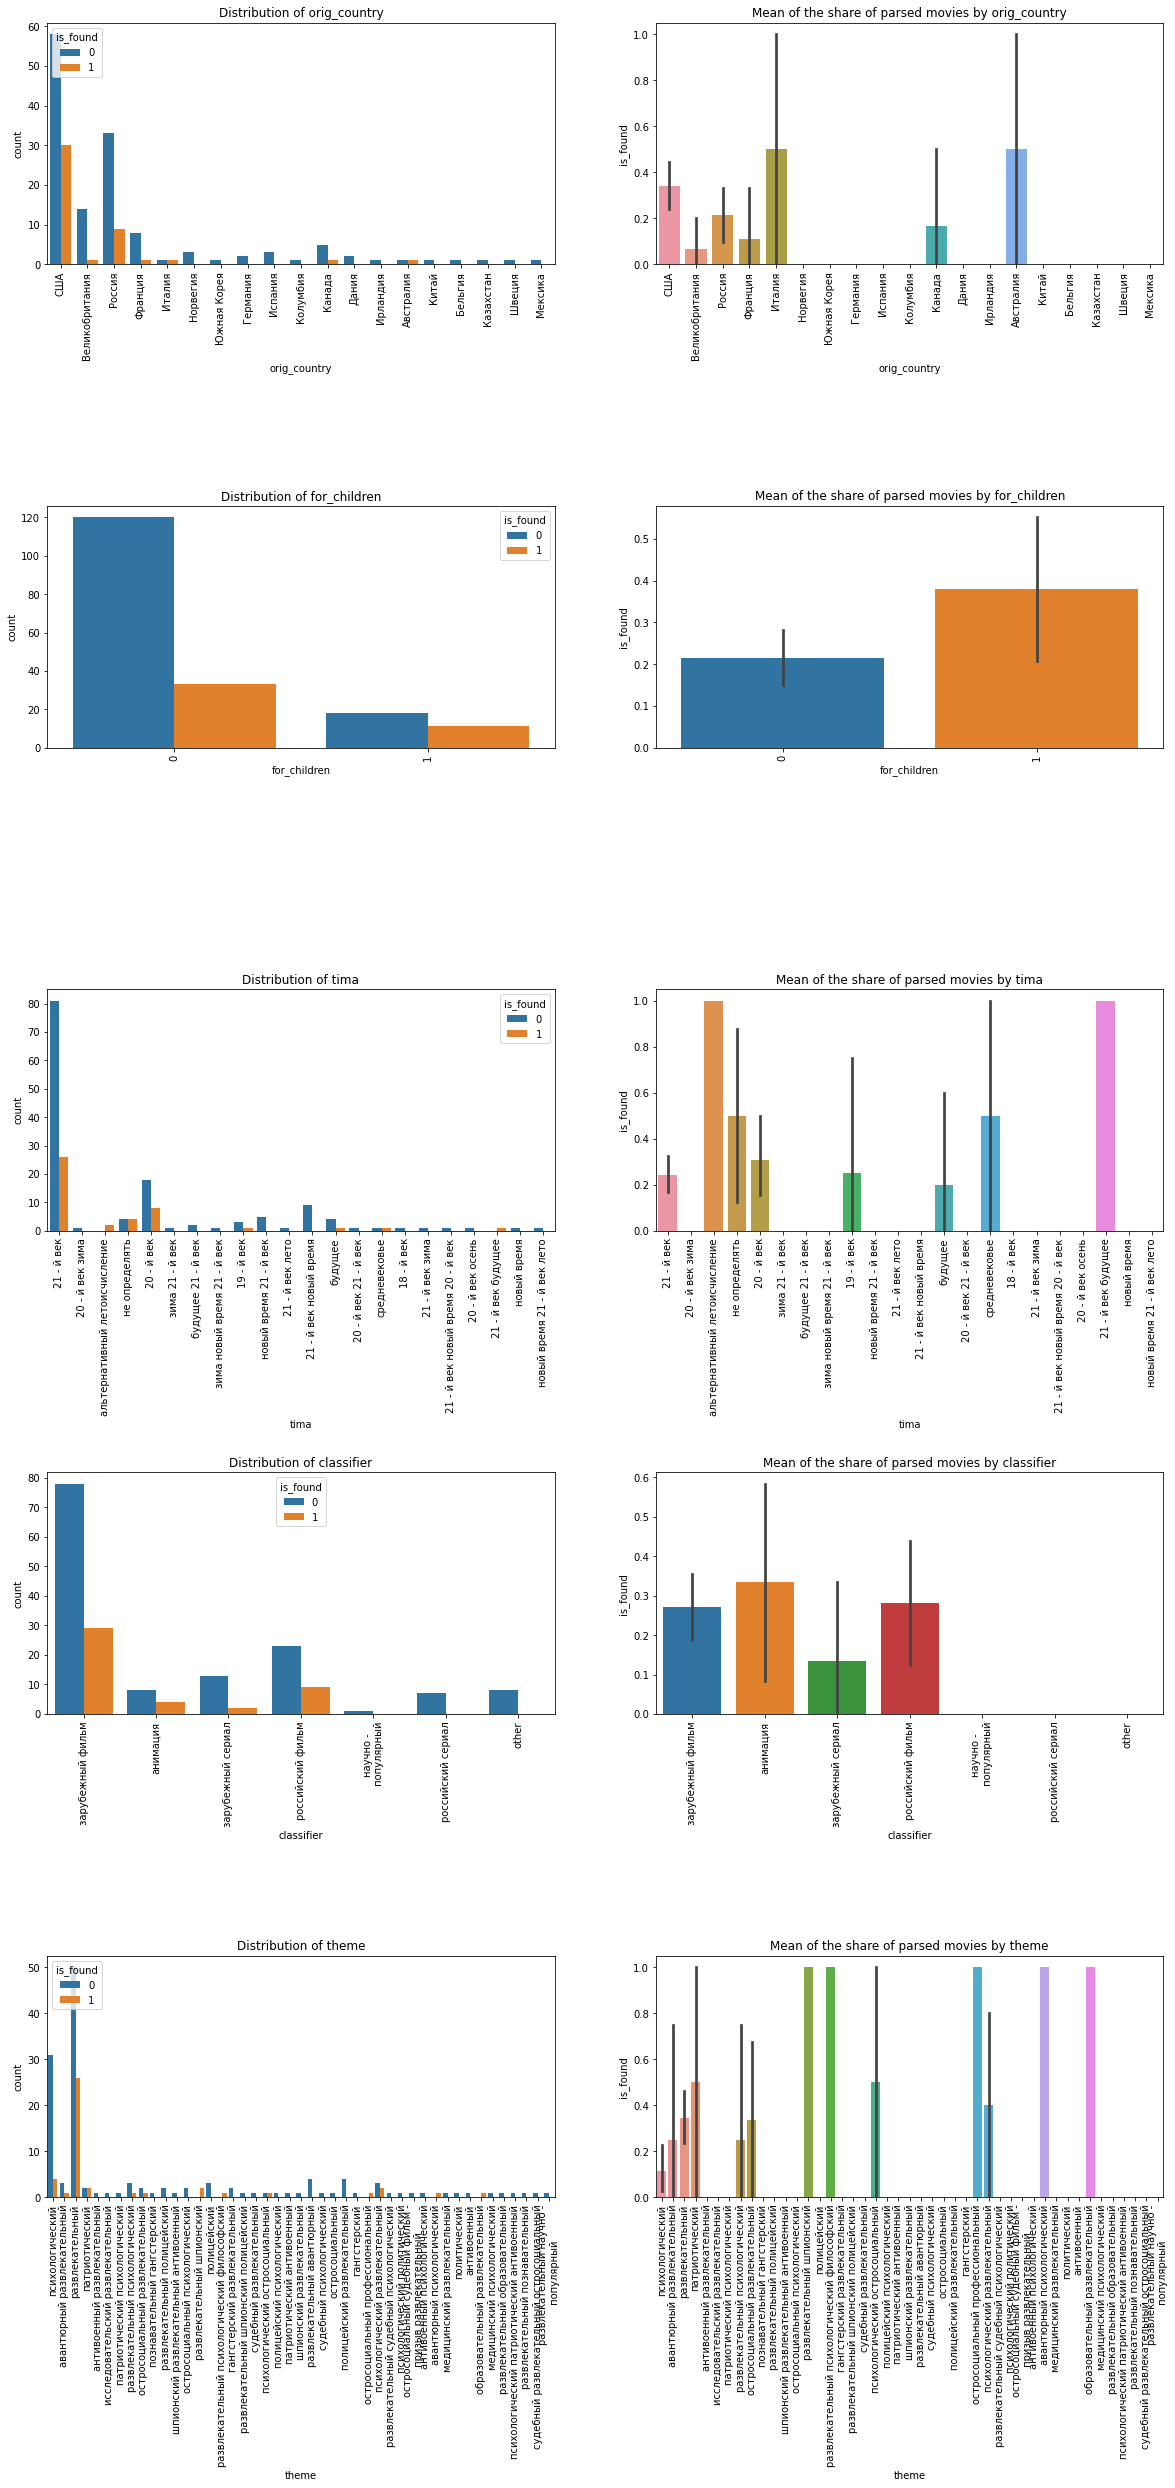

In [145]:
plt.figure(figsize=(20, 40))
for i, column in enumerate(['orig_country', 'orig_country', 'for_children', 'for_children', 'tima', 'tima', 'classifier', 'classifier', 'theme', 'theme']):
    if i % 2 == 1:
        plt.subplot(5, 2, i+1)
        ax = sns.barplot(x=column, y='is_found', data=data)
        plt.title('Mean of the share of parsed movies by {}'.format(column))
        plt.xticks(rotation=90)
    else:
        plt.subplot(5, 2, i+1)
        ax = sns.countplot(x=column, hue='is_found', data=data)
        plt.title('Distribution of {}'.format(column))
        plt.xticks(rotation=90)
    
plt.subplots_adjust(hspace=1)
plt.show()

Теперь визуализируем среднее количество извлекаемых сущностей по категориальным признакам. Сразу видим, что среднее количество извлекаемых сущностей фильмов из США больше, чем отальных по отдельности. Канаду в расчет не берем из-за ограниченного объема выборки. Это говорит о том, что статьи о фильмах из США более насыщены и включают больше сущностей из данных. Среднее количество сущностей по бинарному признаку дети / взрослые примерно одинаков. Также видим, что среднее количество извлекаемых сущностей из новостей о зарубежных фильмах выше, чем о российских, интервалы не пересекаются. Но если принимать в расчет количество уникальных сущностей, то эта разница исчезает и интервалы пересекаются, что говорит о том, что количество извлекаемых уникальных сущностей примерно одинаково по странам.

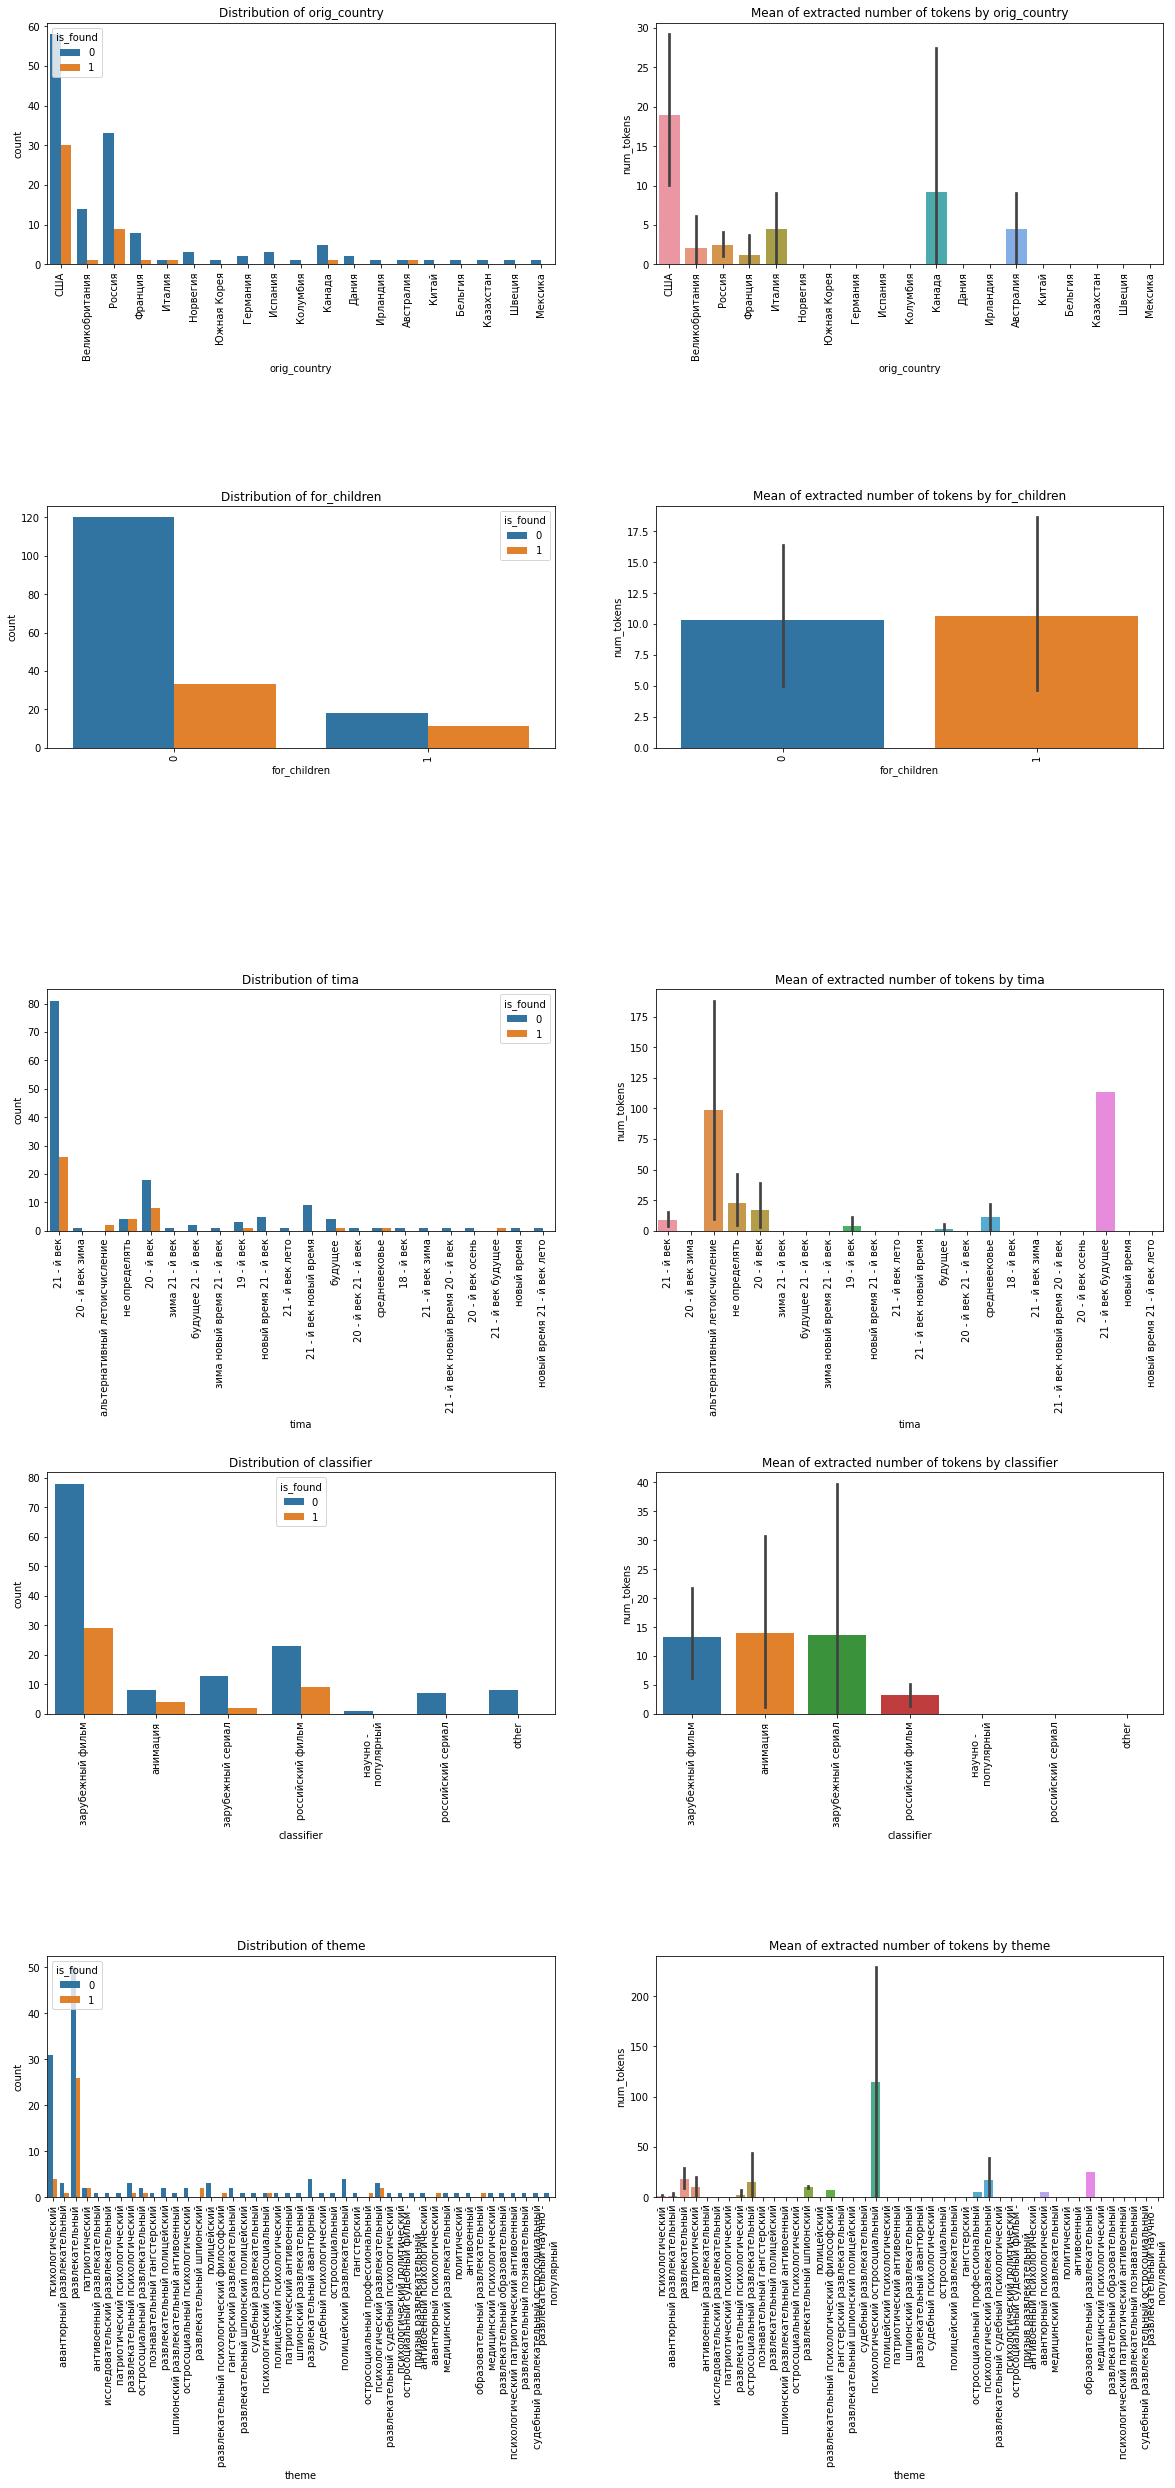

In [146]:
plt.figure(figsize=(20, 40))
for i, column in enumerate(['orig_country', 'orig_country', 'for_children', 'for_children', 'tima', 'tima', 'classifier', 'classifier', 'theme', 'theme']):
    if i % 2 == 1:
        plt.subplot(5, 2, i+1)
        ax = sns.barplot(x=column, y='num_tokens', data=data)
        plt.title('Mean of extracted number of tokens by {}'.format(column))
        plt.xticks(rotation=90)
    else:
        plt.subplot(5, 2, i+1)
        ax = sns.countplot(x=column, hue='is_found', data=data)
        plt.title('Distribution of {}'.format(column))
        plt.xticks(rotation=90)
    
plt.subplots_adjust(hspace=1)
plt.show()

Построим доверительные интервалы для уникальных сущностей.

In [147]:
data['unique_tokens'] = data['tokens'].apply(lambda x: set(x))
data['unq_tokens_num'] = data['unique_tokens'].apply(lambda x: len(x))

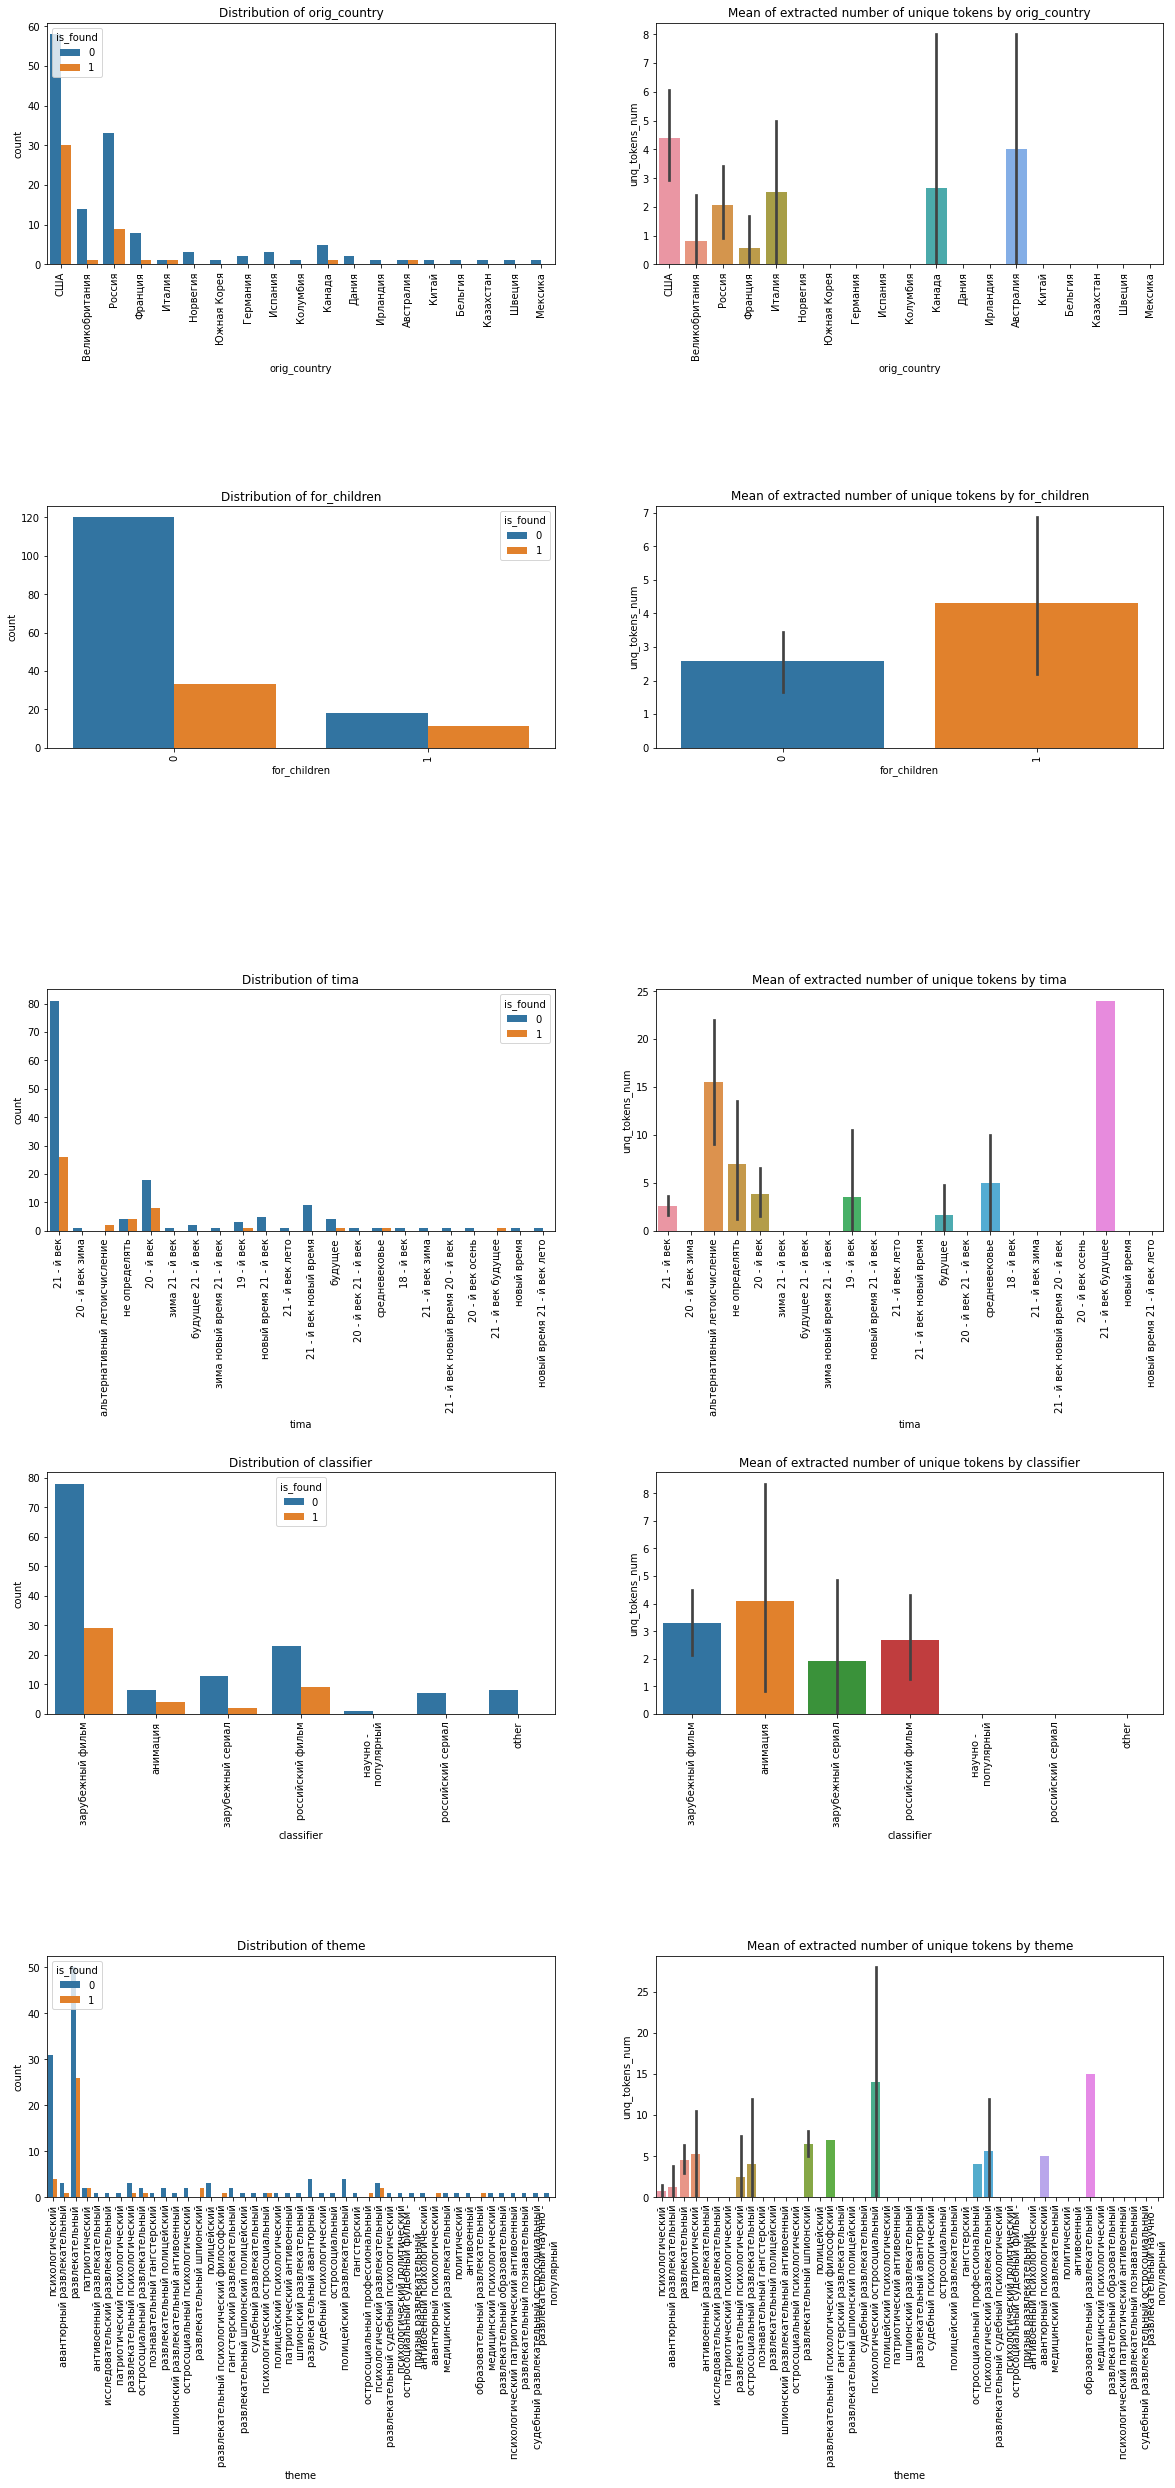

In [148]:
plt.figure(figsize=(20, 40))
for i, column in enumerate(['orig_country', 'orig_country', 'for_children', 'for_children', 'tima', 'tima', 'classifier', 'classifier', 'theme', 'theme']):
    if i % 2 == 1:
        plt.subplot(5, 2, i+1)
        ax = sns.barplot(x=column, y='unq_tokens_num', data=data)
        plt.title('Mean of extracted number of unique tokens by {}'.format(column))
        plt.xticks(rotation=90)
    else:
        plt.subplot(5, 2, i+1)
        ax = sns.countplot(x=column, hue='is_found', data=data)
        plt.title('Distribution of {}'.format(column))
        plt.xticks(rotation=90)
    
plt.subplots_adjust(hspace=1)
plt.show()

Частично проверим, правильно ли определились доверительные интервалы с помощью пакета seaborn. Посмотрим, например, отличаются ли доли найденных фильмов из США и Великобритании. Нулевая гипотеза: доли равны. Альтернативная гипотеза: доли отличаются. Используем Z-критерий для разности долей. Видим, что нулевая гипотеза отклоняется даже на уровне двухсторонней альтернативы с достигаемым уровнем значимости в 0.032323. Доверительный интервал для разности долей состоит из положительный значений.

In [149]:
usa_movies = data[data['orig_country'] == 'США']['is_found'].values
brit_movies = data[data['orig_country'] == 'Великобритания']['is_found'].values

In [150]:
usa_movies

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1])

In [151]:
brit_movies

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [152]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05): 
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    p1 = float(sum(sample1)) / len(sample1) 
    p2 = float(sum(sample2)) / len(sample2)
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2)) 
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    return (left_boundary, right_boundary)

In [153]:
def proportions_diff_z_stat_ind(sample1, sample2): 
    n1 = len(sample1)
    n2 = len(sample2)
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [154]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'): 
    if alternative not in ('two-sided', 'less', 'greater'): 
        raise ValueError("alternative not recognized\n"
                        "should be 'two-sided', 'less' or 'greater'") 
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat))) 
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)
    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [157]:
print('95 confidence interval for a difference between proportions', proportions_diff_confint_ind(usa_movies, brit_movies))

95 confidence interval for a difference between proportions (0.11379516422645311, 0.4346896842583954)


In [158]:
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(usa_movies, brit_movies)))

p-value: 0.032323


In [159]:
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(usa_movies, brit_movies), 'greater'))

p-value: 0.016162


Соберем данные о рейтинге, количестве голосов и кассовых сборах по фильмам.

In [160]:
movie_feeatures = {'За деревьями': [4.2, 345, 24595],
 'Сиротский Бруклин': [7.0, 35000, 18477736],
 'Тайная жизнь домашних животных 2': [6.8, 112000, 430051293],
 'Борьба с моей семьей': [6.6, 11000, 40811919],
 'Беверли-Хиллз 90210': [7.6, 19000, 0],
 'Ржев': [6.6, 34000, 1401156],
 'Солнцестояние': [6.6, 70000, 47863365],
 'Зов волка': [6.2, 8000, 12652790],
 'Переводчики': [6.6, 14000, 2862552],
 'Люди в черном: Интернэшнл': [5.8, 92000, 253890701],
 'Мы': [6.3, 77000, 255184580],
 'Годзилла 2: Король монстров': [5.8, 58000, 386600138],
 'Рэмбо: Последняя кровь': [6.1, 24000, 91490353],
 'Игра престолов': [9.0, 580000, 0],
 'BEEF: Русский хип-хоп': [5.4, 7000, 381571],
 'Как приручить дракона 3': [7.7, 188000, 521799505],
 'Счастливого нового дня смерти': [6.2, 58000, 64600152],
 'Небо измеряется милями': [6.4, 1000, 5752],
 'Как я стал русским': [5.8, 17000, 1668824],
 'Арахисовый сокол': [7.5, 53000, 23728475],
 'Битва за Землю': [5.5, 21000, 8808611],
 'Предатель': [6.5, 3000, 1694027],
 'Туннель: Опасно для жизни': [6.6, 25000, 2654874],
 'Та еще парочка': [6.6, 25000, 2654874],
 'Девятая': [5.8, 8000, 943332],
 'Миллиард': [4.9, 55000, 6606931],
 'Гангстер, коп и дьявол': [6.8, 13000, 25775371],
 'Война миров': [6.4, 9000, 0],
 'Домовой': [6.7, 84000, 1842316],
 'СМЕРШ': [6.7, 52000, 0],
 'Так близко к горизонту': [6.8, 11000, 4476218],
 'Курьер': [4.9, 7000, 272693],
 'Анна': [6.0, 58000, 30918726],
 'Прощай': [5.6, 822, 2232821],
 'Они': [5.7, 10000, 2233978],
 'Решала. Нулевые': [6.7, 6000, 272938],
 'Кома': [6.4, 39000, 2264162],
 'Куда ты пропала, Бернадетт?': [6.7, 12000, 11025353],
 'Трезвый водитель': [5.1, 17000, 3470484],
 'Море соблазна': [6.0, 32000, 14454622],
 'Полицейский седан': [6.4, 2000, 3868],
 'Кокаиновый барон': [5.4, 6000, 111218],
 'Мое прекрасное лето с Софи': [5.3, 3000, 644582],
 'Достать ножи': [7.9, 279000, 311394031],
 'В клетке': [6.7, 7000, 0],
 'Королевские каникулы': [6.2, 12000, 12957767],
 'Человек-Паук: Вдали от дома': [7.2, 192000, 1131927996],
 'Три секунды': [6.6, 14000, 2627248],
 'Победители': [7.1, 1000, 0],
 'Джокер': [8.0, 379000, 1074251311],
 'В тихом омуте': [6.8, 17000, 1098207],
 'Нэнси Дрю': [6.7, 11000, 0],
 'Братство': [6.6, 41000, 739934],
 'Алита: Боевой ангел': [7.1, 263000, 404852543],
 'Камуфляж и шпионаж': [7.1, 50000, 171616764],
 'Лови момент': [5.3, 6000, 269047],
 'Дождливый день в Нью-Йорке': [7.2, 39000, 22002075],
 'Кровь и сокровища': [6.3, 498, 0],
 'Дело Коллини': [7.4, 17000, 2752807],
 'Люди Икс: Темный Феникс': [5.9, 110000, 252442974],
 'Однажды в… Голливуде': [7.6, 249000, 372679647],
 'Пункт назначения: Смайл': [5.1, 19000, 1772204],
 'Грязные деньги': [0, 76, 0],
 'Али, рули!': [6.1, 19000, 32390945],
 'Невероятный мир глазами Энцо': [7.9, 23000, 33766787],
 'Я иду искать': [6.8, 78000, 57615777],
 'Анатомия страсти': [8.2, 56000, 0],
 'Клаустрофобы': [6.7, 65000, 155712077],
 'Путь домой': [7.2, 36000, 80708134],
 'Звериная ярость': [5.3, 2000, 84630],
 'Мидуэй': [6.4, 15000, 125648634],
 'Пиноккио': [6.4, 8000, 20277042],
 'Волшебник': [6.3, 3000, 223564],
 'Звездные Войны: Скайуокер. Восход': [6.0, 96000, 1074144248],
 'Крёстный отец Гарлема': [7.8, 7000, 0],
 'Эспен в поисках золотого замка': [6.6, 8000, 2995507],
 'КОП': [6.4, 1000, 0],
 'Лего Фильм 2': [6.6, 23000, 192306508],
 'Бабушка легкого поведения 2': [5.4, 46000, 7209951],
 'Скандал': [6.3, 28000, 59875877],
 'Окей, Лекси!': [6.0, 19000, 9341824],
 'Эбигейл': [5.2, 17000, 1940234],
 'Оно 2': [6.6, 154000, 473093228],
 'Шазам!': [6.8, 138000, 365971656],
 'Хорошая жена (2019)': [6.2, 1000, 0],
 'Опасные мамочки': [0, 141, 0],
 'Хорошая жена': [8.0, 15000, 0],
 'Поместье в Индии': [7.0, 1000, 0],
 'Дело Ричарда Джуэлла': [7.6, 38000, 43745542],
 'Выше неба': [5.8, 2000, 127533],
 'Мелкая': [5.7, 3000, 48987096],
 'Наследие: Застывшая кровь': [5.0, 2000, 1009888],
 'Лев Яшин. Вратарь моей мечты': [6.9, 41000, 1778723],
 'Брексит': [6.6, 3000, 0],
 'Юморист': [6.5, 17000, 341743],
 'Отрыв': [5.1, 14000, 371557],
 'Темные воды': [7.7, 44000, 22984545],
 'Другой': [5.3, 10000, 3373474],
 'Спасти Ленинград': [5.4, 15000, 3076272],
 'Красивый, плохой, злой': [6.8, 101000, 9813468],
 'История игрушек 4': [7.6, 74000, 1073394593],
 'Терминатор: Темные судьбы': [5.8, 90000, 261119292],
 'Кладбище домашних животных': [5.6, 71000, 113118226],
 'Дар': [5.6, 1000, 1889],
 'Хеллбой': [5.8, 76000, 44664690],
 'Дитя робота': [6.6, 38000, 643593],
 'Дорогой папа': [6.0, 4000, 645377],
 'Рождённый стать королём': [5.6, 9000, 32140970],
 '21 мост': [6.6, 32000, 49939757],
 'Синяя бездна 2': [5.3, 10000, 47582563],
 'Отпетые мошенницы': [6.1, 87000, 95017038],
 'Щегол': [6.5, 22000, 9932621],
 'Стекло': [6.4, 159000, 246999039],
 'Куриоса': [5.7, 14000, 114430],
 'Команда мечты': [5.3, 1000, 307916],
 'Тест на беременность': [8.1, 48000, 0],
 'Ленин. Неизбежность': [5.4, 1000, 26719],
 'Измени или умри': [5.6, 2000, 0],
 'Ходячие мертвецы': [8.0, 229000, 605764],
 'Балканский рубеж': [7.3, 165000, 5849400],
 'Искусство обмана': [5.4, 7000, 641509],
 'Котел': [5.5, 436, 0],
 'Папа, сдохни': [6.8, 28000, 40995],
 'Пандора': [4.6, 1000, 0],
 'Старые счеты': [4.9, 1000, 171216],
 'Ядовитая роза': [5.2, 4000, 323754],
 'Семь ужинов': [6.1, 22000, 1700268],
 'Робо': [4.8, 5000, 1106307],
 'Остров': [0, 0, 0],
 'Детские игры': [5.7, 15000, 44902237],
 'Капитан Марвел': [6.5, 218000, 1128274794],
 'После': [5.8, 81000, 69733482],
 'Донбасс. Окраина': [6.2, 12000, 172100],
 'Покемон. Детектив Пикачу': [6.6, 108000, 433005346],
 'Девушки бывают разные': [4.0, 8000, 1933579],
 'Нэнси Дрю и потайная лестница': [5.8, 2000, 623088],
 'Проклятие плачущей': [5.4, 17000, 123133739],
 'Хороший доктор': [7.1, 14000, 6263677],
 'В метре друг от друга': [7.2, 95000, 91522094],
 'Т-34': [6.5, 233000, 35950901],
 'Джон Уик 3': [6.7 , 166000, 326709727],
 'Мстители: Финал': [7.6, 409000, 2797800564],
 'Падение ангела': [6.2, 25000, 146661977],
 'Обратный отсчет': [5.6, 18000, 48021766],
 'Королевский корги': [5.7, 46000, 36120360],
 'Ты умеешь хранить секреты?': [5.7, 10000, 1378160],
 'Солдатик': [6.9, 14000, 0],
 'Вистинг': [6.9, 1000, 0],
 'Король Лев': [7.1, 167000, 1656943394],
 'Страшные истории для рассказа в темноте': [6.1, 55000, 104545505],
 'Проклятие Аннабель 3': [5.9, 36000, 231252591],
 'Герой': [5.3, 17000, 2889720],
 'Фиксики против Кработов': [7.5, 51000, 6431354],
 'Поток': [6.2, 363, 0],
 'ЛЕГО. Мир юрского периода: Легенда острова Нублар': [0, 0, 0],
 'Форсаж: Хоббс и Шоу': [6.3, 125000, 759056935],
 'Ма': [5.5, 23000, 61105672],
 'Королева сердец': [6.4, 7000, 437005],
 'Виктор Лессар': [0, 36, 0],
 'Аким': [6.7, 2000, 0],
 'Дамбо': [6.8, 62000, 353284621],
 'Стриптизерши': [5.9, 28000, 157563598],
 'Ибица': [5.6, 3000, 6822634],
 'Лучшие в Лос-Анджелесе': [5.9, 542, 0],
 'Комната желаний': [6.1, 27000, 27957],
 'Подлинная история банды Келли': [5.8, 8000, 467198],
 'Война миров (2019)': [6.4, 9000, 0],
 'Идеальный пациент': [6.5, 14000, 153129],
 'Дверь в лесу': [4.2, 946, 18861],
 'Ford против Ferrari': [8.2, 234000, 225508210],
 'Доктор Сон': [7.2, 76000, 72381712],
 'Код 8': [6.1, 10000, 157209],
 'Сельма в городе призраков': [5.4, 3000, 3689400],
 'Холодное сердце 2': [7.1, 126000, 1450026933],
 'К звездам': [6.4, 78000, 127461872],
 'Angry Birds 2 в кино': [6.6, 32000, 147792047],
 'Хороший лжец': [6.6, 14000, 33856058],
 'План побега 3': [4.3, 7000, 1766092],
 'Аладдин': [7.3, 207000, 1050693953],
 'Расплата': [6.6, 316, 0],
 'Мосгаз. Новое дело майора Черкасова': [7.3, 3000, 0],
 'Малефисента: Владычица тьмы': [6.9, 140000, 491730089]}

In [161]:
rating = [v[0] for v in movie_feeatures.values()]
votes = [v[1] for v in movie_feeatures.values()]
receipts = [v[2] for v in movie_feeatures.values()]

In [162]:
data['rating'] = rating

In [163]:
data['votes'] = votes

In [164]:
data['receipts'] = receipts

Посмотрим на средние рейтинга фильмов, количества голосов и кассовых сборов относительно бинарного признака is_found (нашел ли аггоритм фильм или нет). Видим, что отличие статистически значимо во всех трех случаях. Это означает, что алгоритм чаще находит фильмы с бОльшим рейтингом, или бюджетом, или количеством голосов. Правда, несмотря на то, что интервалы не пересекаются во всех трех случаях, в случае с рейтингом, границы интервалов расположены близко друг у другу, средние, оцененные по выборкам также примерно равны, алгоритм все равно различает эту небольшую разницу, но это может быть связано с тем, что стандартное отклонение признака небольшое и составляет 1.34 при среднем в 6.15. В случае же с количесвом голосов и кассовыми сборами, алгоритм менее успешен. Основной action point: модифицировать алгоритм таким образом, чтобы он находил больше фильмов с маленьким количесвом голосов и кассовыми сборами. Потенциальные будущие действия: выявить другие признаки, позволяющие уловить необходимые улучшения алгоритма.

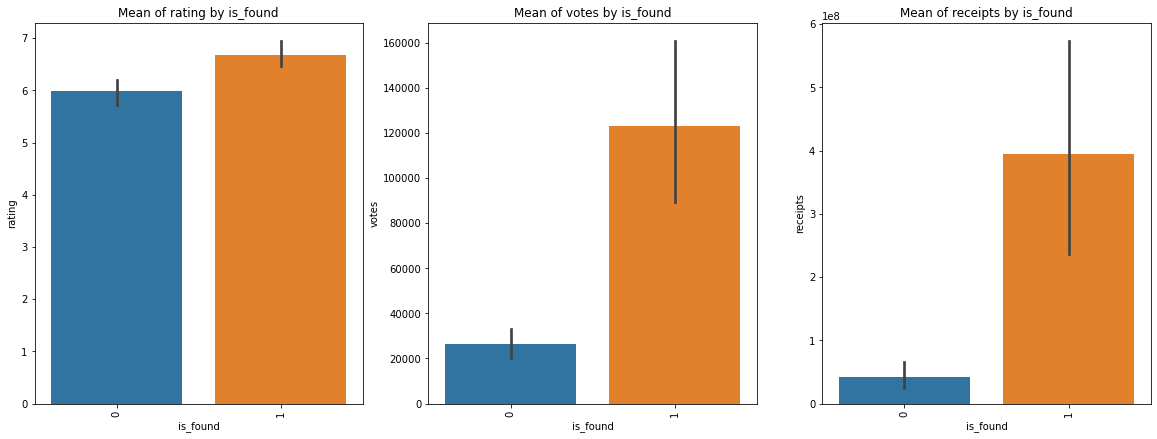

In [165]:
plt.figure(figsize=(20, 7))
for i, column in enumerate(['rating', 'votes', 'receipts']):
    plt.subplot(1, 3, i+1)
    ax = sns.barplot(x='is_found', y=column, data=data)
    plt.title('Mean of {} by is_found'.format(column))
    plt.xticks(rotation=90)
plt.subplots_adjust(hspace=1)
plt.show()

In [166]:
np.std(data['rating'].values), np.mean(data['rating'].values)

(1.3386776021497047, 6.151648351648351)

In [167]:
np.std(data['votes'].values), np.mean(data['votes'].values)

(79803.34452735973, 49849.01648351648)

In [168]:
np.std(data['receipts'].values), np.mean(data['receipts'].values)

(333235695.8615556, 126887460.11538461)

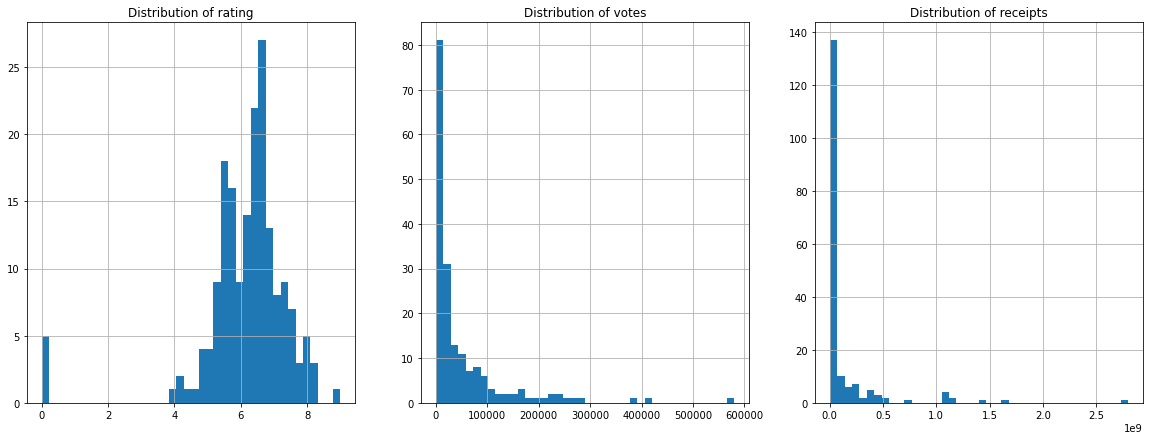

In [190]:
plt.figure(figsize=(20, 7))
for i, column in enumerate(['rating', 'votes', 'receipts']):
    plt.subplot(1, 3, i+1)
    ax = data[column].hist(bins=40)
    plt.title('Distribution of {}'.format(column))
plt.show()

Проведем визуализацию по всем трем признакам

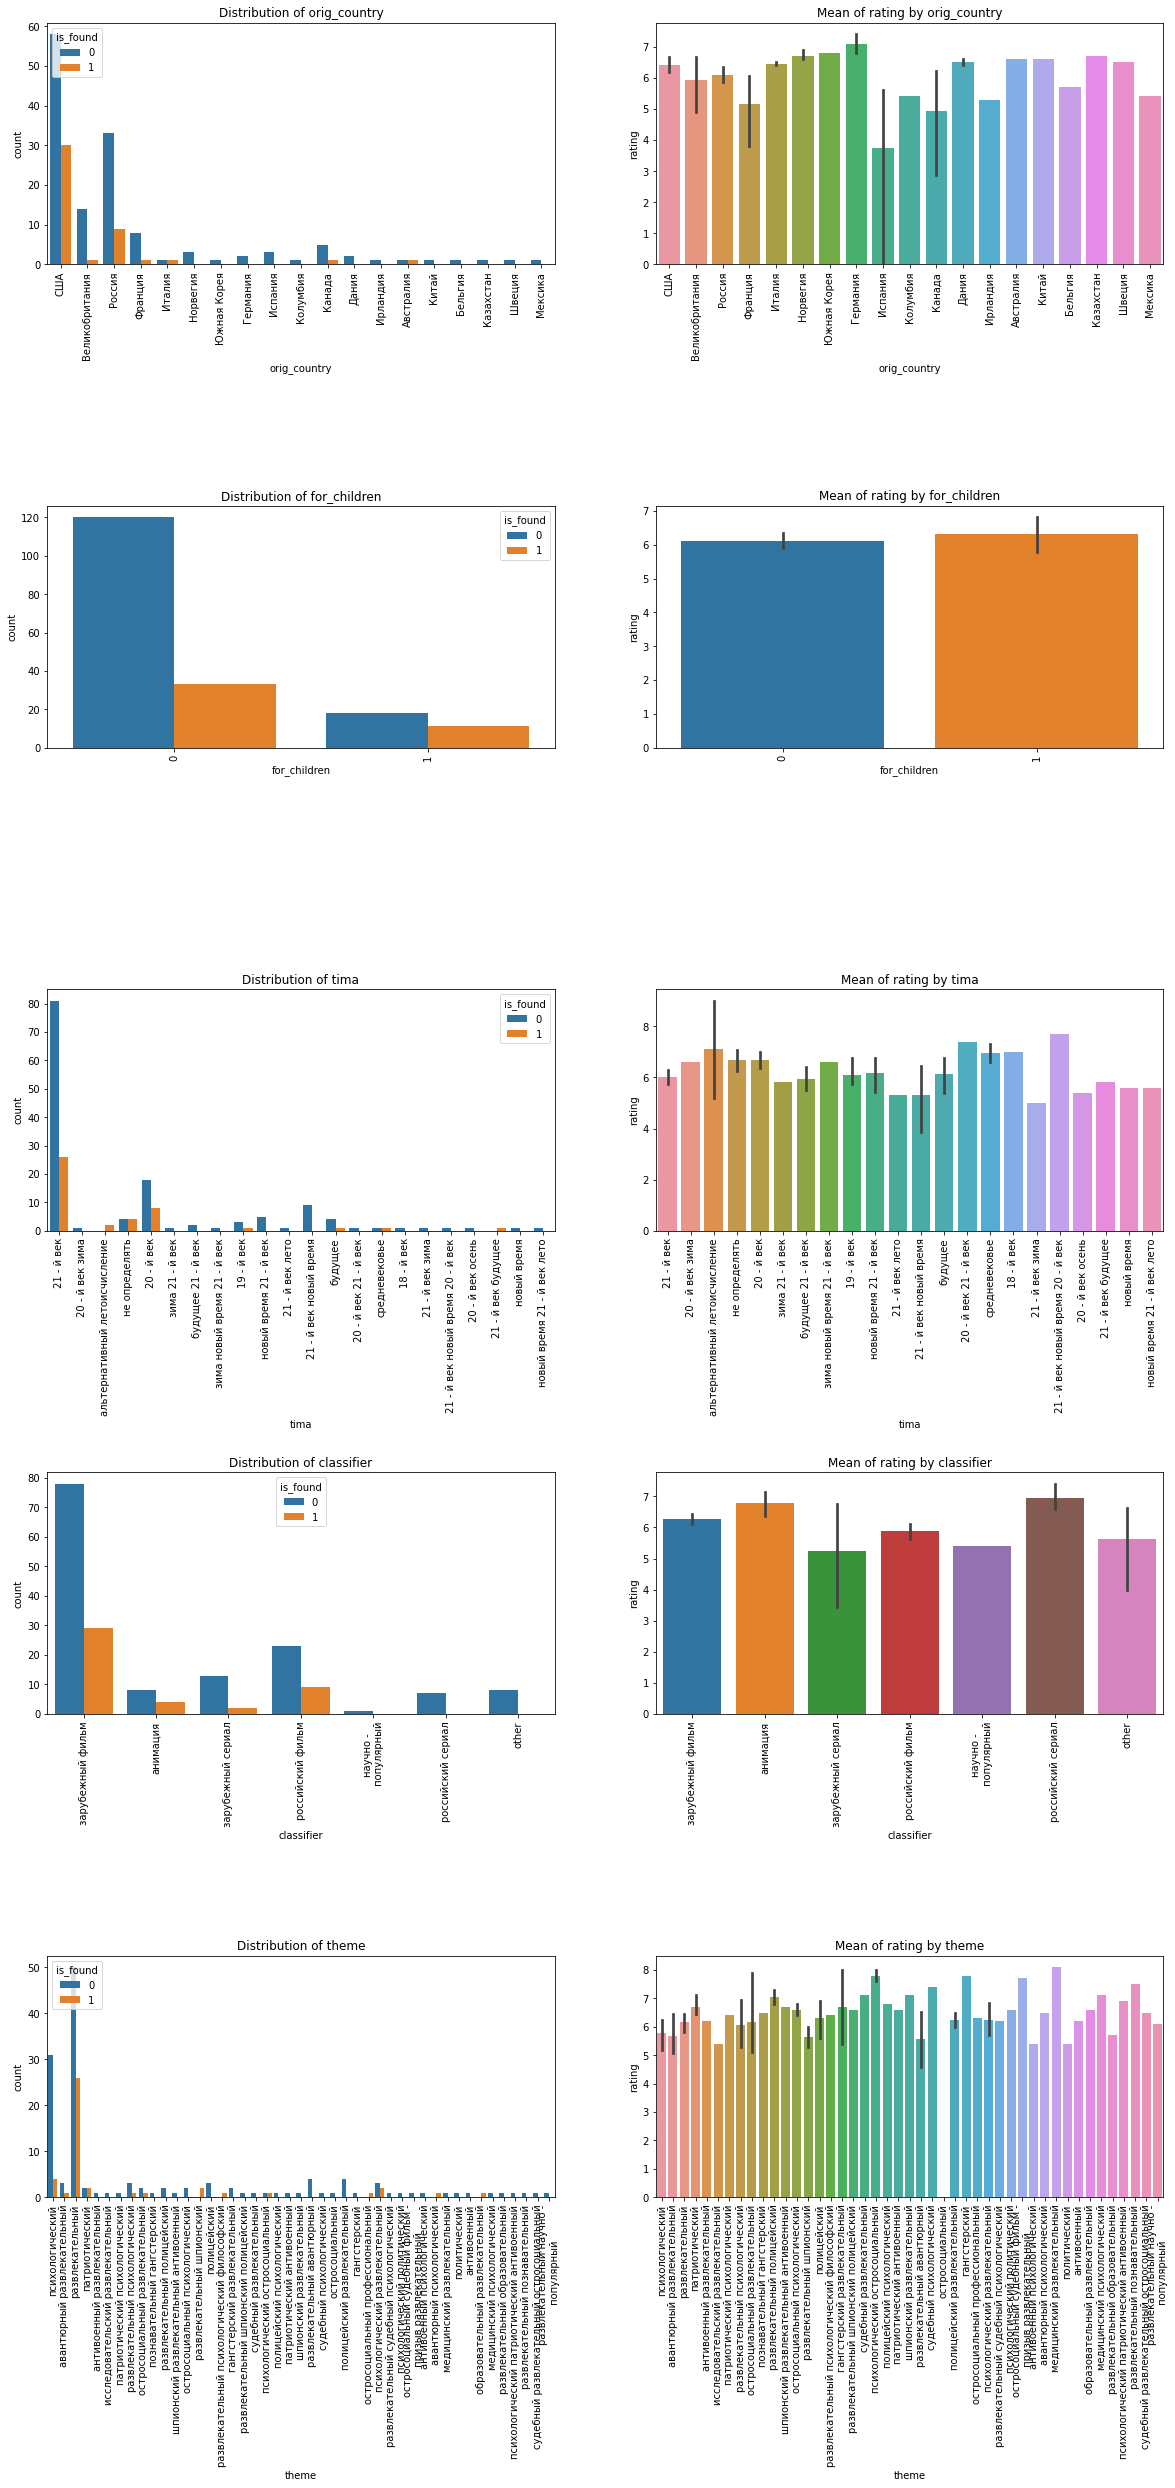

In [170]:
plt.figure(figsize=(20, 40))
for i, column in enumerate(['orig_country', 'orig_country', 'for_children', 'for_children', 'tima', 'tima', 'classifier', 'classifier', 'theme', 'theme']):
    if i % 2 == 1:
        plt.subplot(5, 2, i+1)
        ax = sns.barplot(x=column, y='rating', data=data)
        plt.title('Mean of rating by {}'.format(column))
        plt.xticks(rotation=90)
    else:
        plt.subplot(5, 2, i+1)
        ax = sns.countplot(x=column, hue='is_found', data=data)
        plt.title('Distribution of {}'.format(column))
        plt.xticks(rotation=90)
    
plt.subplots_adjust(hspace=1)
plt.show()

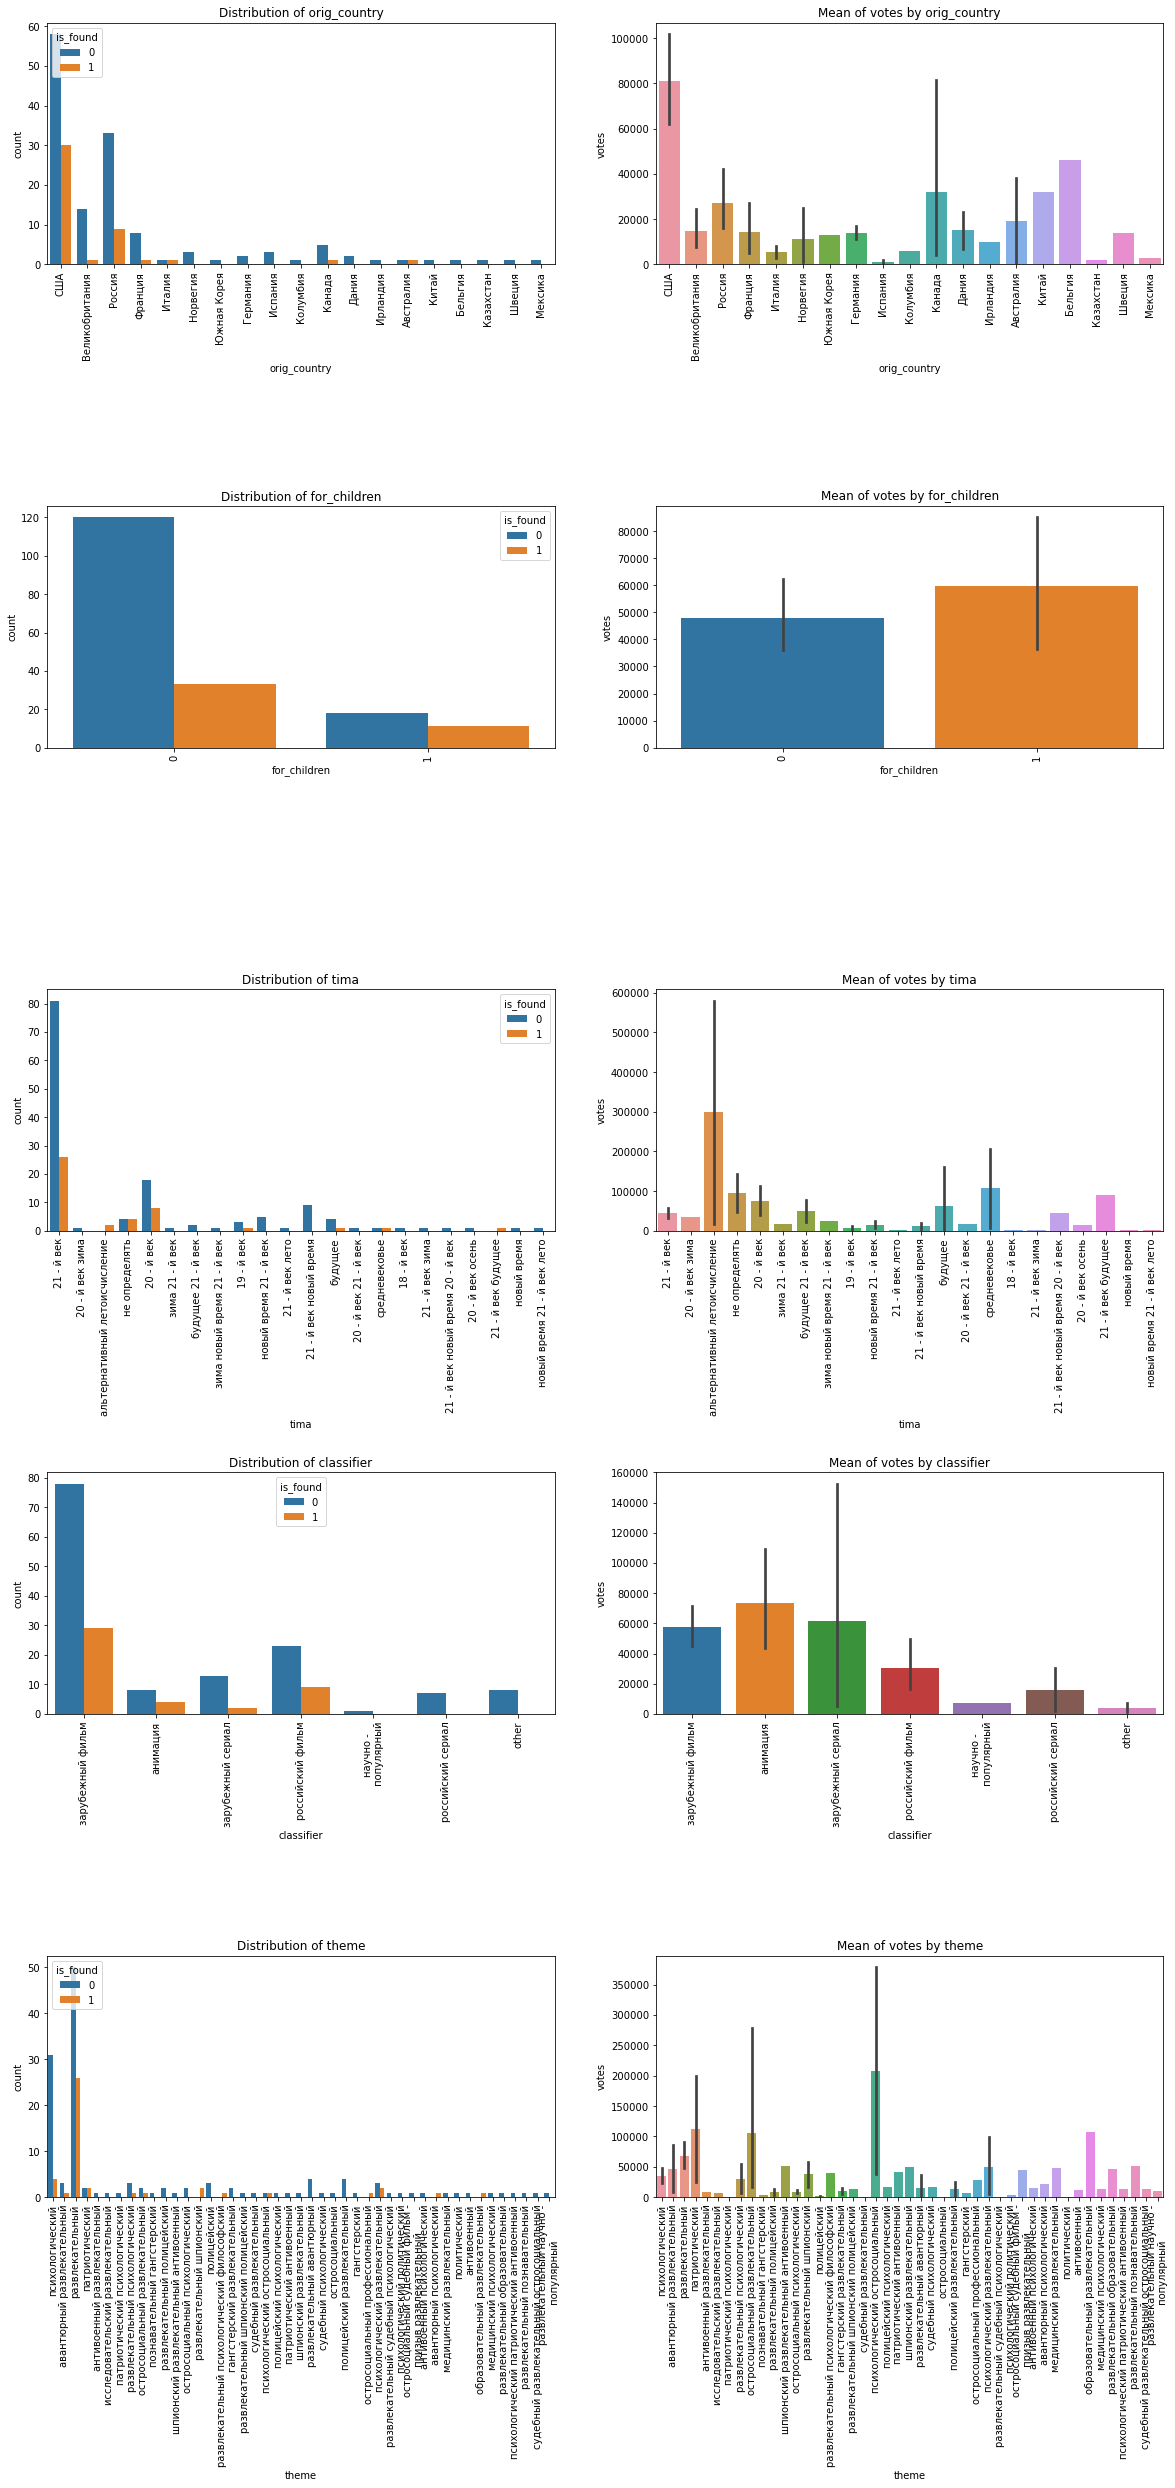

In [171]:
plt.figure(figsize=(20, 40))
for i, column in enumerate(['orig_country', 'orig_country', 'for_children', 'for_children', 'tima', 'tima', 'classifier', 'classifier', 'theme', 'theme']):
    if i % 2 == 1:
        plt.subplot(5, 2, i+1)
        ax = sns.barplot(x=column, y='votes', data=data)
        plt.title('Mean of votes by {}'.format(column))
        plt.xticks(rotation=90)
    else:
        plt.subplot(5, 2, i+1)
        ax = sns.countplot(x=column, hue='is_found', data=data)
        plt.title('Distribution of {}'.format(column))
        plt.xticks(rotation=90)
    
plt.subplots_adjust(hspace=1)
plt.show()

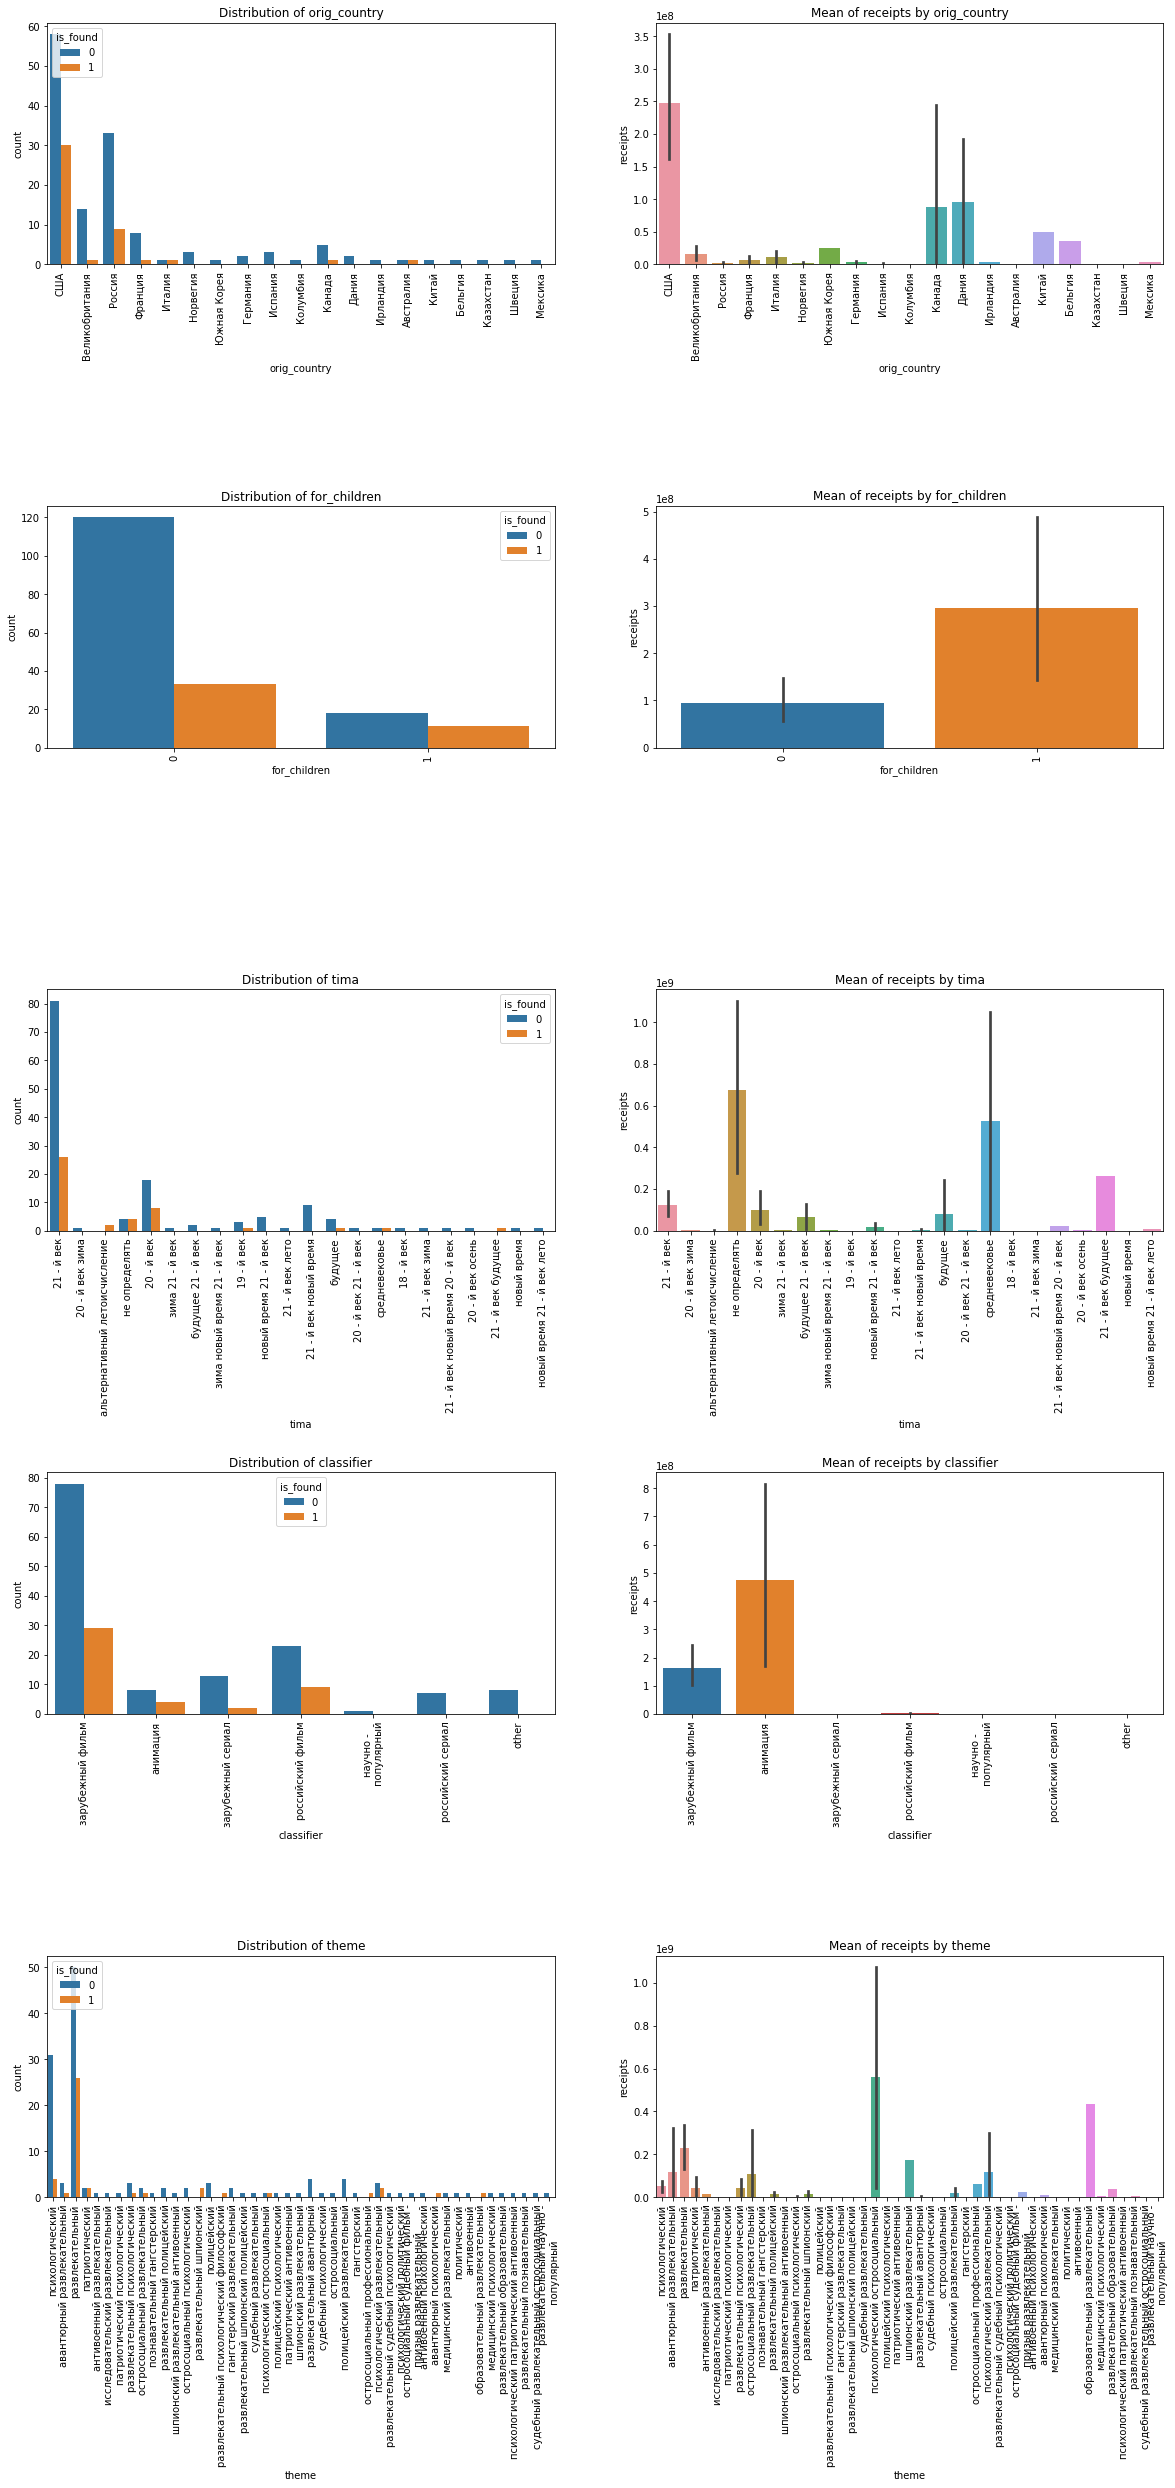

In [172]:
plt.figure(figsize=(20, 40))
for i, column in enumerate(['orig_country', 'orig_country', 'for_children', 'for_children', 'tima', 'tima', 'classifier', 'classifier', 'theme', 'theme']):
    if i % 2 == 1:
        plt.subplot(5, 2, i+1)
        ax = sns.barplot(x=column, y='receipts', data=data)
        plt.title('Mean of receipts by {}'.format(column))
        plt.xticks(rotation=90)
    else:
        plt.subplot(5, 2, i+1)
        ax = sns.countplot(x=column, hue='is_found', data=data)
        plt.title('Distribution of {}'.format(column))
        plt.xticks(rotation=90)
    
plt.subplots_adjust(hspace=1)
plt.show()

In [174]:
data

,object_id,title,orig_country,release_date,for_children,about,place,tima,theme,classifier,...,release_year,all,tokens,num_tokens,is_found,unique_tokens,unq_tokens_num,rating,votes,receipts
0,419411,За деревьями,США,21.11.2019,0,"[демон, отношение, пара, путешествие, борьба, ...",лес джунгли индия,21 - й век,психологический,зарубежный фильм,...,[2019],"[демон, отношение, пара, путешествие, борьба, ...",[],0,0,{},0,4.2,345,24595
1,210525,Сиротский Бруклин,США,30.08.2019,0,"[потеря, близкие, частный, детектив, сыщик, пр...",сша нью -\n йорк сша,21 - й век,психологический,зарубежный фильм,...,[2019],"[потеря, близкие, частный, детектив, сыщик, пр...","[частный, детектив, расследование, -\n, -\n, ф...",8,1,"{фильм, бруклин, -\n, детектив, расследование,...",7,7.0,35000,18477736
2,176620,Тайная жизнь домашних животных 2,США,24.05.2019,1,"[психологический, расстройство, переезд, ребен...",большой город сша,21 - й век,авантюрный развлекательный,анимация,...,[2019],"[психологический, расстройство, переезд, ребен...","[тайный, жизнь, домашний, животный, 2]",5,1,"{жизнь, 2, животный, домашний, тайный}",5,6.8,112000,430051293
3,185387,Борьба с моей семьей,Великобритания,28.01.2019,0,"[семейный, конфликт, подросток, успех, отношен...",великобритания сша,21 - й век,развлекательный,зарубежный фильм,...,[2019],"[семейный, конфликт, подросток, успех, отношен...",[],0,0,{},0,6.6,11000,40811919
4,12678,Беверли-Хиллз 90210,США,07.08.2019,0,"[дружба, отношение, мужчина, женщина, любовь, ...",сша маленький городок,21 - й век,развлекательный,зарубежный сериал,...,[2019],"[дружба, отношение, мужчина, женщина, любовь, ...",[],0,0,{},0,7.6,19000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,205000,План побега 3,США,08.06.2019,0,"[отношение, миссия, /\n, цель, /\n, задание, к...",сша,21 - й век,развлекательный,зарубежный фильм,...,[2019],"[отношение, миссия, /\n, цель, /\n, задание, к...",[],0,0,{},0,4.3,7000,1766092
178,177691,Аладдин,США,08.05.2019,1,"[богач, храбрость, магия, волшебство, преображ...",вымышленный страна (\n город )\n,средневековье,развлекательный,зарубежный фильм,...,[2019],"[богач, храбрость, магия, волшебство, преображ...","[(\n, )\n, фильм, аладдин, джинн, (\n, фильм, ...",22,1,"{со, аладдин, желание, принцесса, фильм, (\n, ...",10,7.3,207000,1050693953
179,12915,Расплата,Австралия,01.01.2019,0,"[убийство, убийца, семья, отец, ребенок, серий...",сша калифорния сша пригород,21 - й век,психологический,зарубежный сериал,...,[2019],"[убийство, убийца, семья, отец, ребенок, серий...",[],0,0,{},0,6.6,316,0
180,12987,Мосгаз. Новое дело майора Черкасова,Россия,21.10.2019,0,"[лошадь, отец, ребенок, настоящий, мужчина, от...",ссср,20 - й век,развлекательный полицейский,российский сериал,...,[2019],"[лошадь, отец, ребенок, настоящий, мужчина, от...",[],0,0,{},0,7.3,3000,0


In [191]:
data.columns

Index(['object_id', 'title', 'orig_country', 'release_date', 'for_children',
       'about', 'place', 'tima', 'theme', 'classifier', 'title_lem',
       'orig_country_lem', 'release_date_stem', 'release_year', 'all',
       'tokens', 'num_tokens', 'is_found', 'unique_tokens', 'unq_tokens_num',
       'rating', 'votes', 'receipts'],
      dtype='object')